# XGBoost




[[XGB Document](https://xgboost.readthedocs.io/en/stable/index.html)]
- Extreme Gradient Boosting의 약자
- 베이스모델로 의사결정나무를 사용하는 GBM 기반의 머신러닝 알고리즘
- GBM과 동일하게 이전라운드에서의 예측오류를 다음 라운드의 모델 학습에 반영시킨다.
- 하지만 GBM과 달리 학습을 위한 목적함수에 트리 규제항(Regularization Term) $Ω(ℎ)$이 추가됨  
- 병렬 학습이 가능하여 GBM에 비해 학습시간이 빠르며, 규제항으로 인하여 과적합이 발생할 가능성이 더 낮다는 장점      

- 규제항 $Ω(ℎ)$은 트리의 복잡성에 패널티를 부여하는 항. 과적합 방지
    - ①번 항은 트리가 커짐에 따라 패널티 부여
    - ②번 항은 특정 끝노드에서의 출력값이 커지는 것에 대한 패널티
- 𝛾는 하이퍼파라미터로 트리의 복잡도에 대한 패널티를 의미한다. 값을 크게 할 수록 더욱 많은 가지치기가 수행됨.

In [ ]:
# # 한글 폰트 설치
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

### 1. 데이터 로드 및 전처리

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 데이터 로드
URL = "/content/drive/MyDrive/SIL/WORK/DSS 머신러닝2/" # 데이터 위치 설정
data = df = pd.read_csv(URL+"data/Fault_data.csv",encoding="EUC-KR")

In [ ]:
data.drop(["자재구분","END_DATE_TIME"],axis=1,inplace=True)
data.dropna(axis=1,inplace=True)

#X,Y 분할
Y=data["Y"].copy()
X=data.drop("Y",axis=1)
X.head(3)

CHAMBER  TAE.STDDEV0  TAE.MEAN0  TAE.RANGE0  PC.STDDEV0  PC.MEAN0  \
0        4     0.044554  38.083127    0.254154    0.124753  0.044329   
1        2     0.034801  38.052395    0.063538    0.177575  0.342131   
2        3     0.030089  38.046407    0.127080    0.137559  0.063983   

   PC.RANGE0  CROT.STDDEV0  CROT.MEAN0  CROT.RANGE0  ...  PC.RANGE12  \
0   0.439883             0          35            0  ...   17.350926   
1   0.439883             0          27            0  ...    1.466280   
2   0.488759             0          15            0  ...   13.098728   

   TAE.STDDEV9  TAE.MEAN9  TAE.RANGE9  CROT.STDDEV9  CROT.MEAN9  CROT.RANGE9  \
0     0.032832  35.011650    0.127077             0          35            0   
1     0.020858  35.550245    0.063540             0          27            0   
2     0.021635  36.013373    0.063538             0          15            0   

   PC.STDDEV9   PC.MEAN9  PC.RANGE9  
0    0.405343  45.124841   3.079182  
1    1.923012  45.350277  15.004887  
2    0.161640  45.071393   0.977516  

[3 rows x 136 columns]

### 2. 평가 지표 함수

In [ ]:
# 평가 지표 출력 함수
def print_all_reg(Y_test,pred):
    print("model의 MSE 값은 {:.3f}".format(mean_squared_error(Y_test,pred)))
    print("model의 MAE 값은 {:.3f}".format(mean_absolute_error(Y_test, pred)))
    print("model의 MAPE 값은 {:.3f}".format(mean_absolute_percentage_error(Y_test, pred)))
    print("model의 r2 값은 {:.3f}".format(r2_score(Y_test, pred)))

### 3. 모델 학습 및 예측

In [ ]:

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=5,shuffle =True)

[[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)]  
**sklearn.model_selection.train_test_split**
- **test_size** : float or int, default = 0.25, 정수값일시 test사이즈로 설정하고 싶은 샘플 수 입력
- **train_size** : float or int, default = None
- **random_state** : int, default = None, 랜덤 seed값 설정, 같은 seed 내에선 동일결과 추출
- **shuffle** : bool, default = True, 데이터셋 무작위 추출, 시계열 데이터와 같이 순차적 추출이 필요한 경우엔 Shuffle = False!
- **stratify** : array-like, default = None, True일시 계층적 샘플링 진행 ([참고](https://www.investopedia.com/terms/stratified_random_sampling.asp))

[[XGB Parameters](https://xgboost.readthedocs.io/en/stable/parameter.html)]
### **General Parameters**
- **booster** [default= gbtree ] : 어떤 부스터 구조를 쓸지 결정한다. 의사결정기반모형(gbtree), 선형모형(gblinear), dart가 있다.
- **verbosity** [default=1] : 유효한 값은 0 (무음), 1 (경고), 2 (정보), 3 (디버그)
- **nthread** [default=사용가능한 최대수] : 학습에 사용할 CPU thread 개수로, 자동적으로 컴퓨팅 가능한 최대값을 사용
- **silent** [deafault=1] : 결과메시지 출력 여부 설정, 1일시 메시지가 나타나지 않음.
### **Booster Parameters**
- **n_estimators** [default=100] : 베이스모델인 트리 개수
- **eta** [alias = learning_rate, default=0.3] : learning rate와 동일하며, 0~1사이 값을 지정한다. 클수록 과적합 가능성 증대, 작을수록 학습 소요시간 증가
- **gamma** [alias: min_split_loss, deafult=0] : leaf node에서 추가분할 여부를 결정할 최소손실 감소값이며, 해당 값보다 손실이 크게 감소할 때 트리 추가 분할. 값이 클수록 과적합이 감소된다.
- **max_depth** [default=6] : 최대 트리 깊이, 일반적으로 3~10의 값으로 설정, 0 지정시 트리 깊이의 제한이 없음, 과대적합에 가장 큰 영향을 주는 중요 하이퍼 파라미터.
- **lambda** [alias=reg_lambda, default=1] : l2 regularization(Ridge) 적용값으로, 값이 커질수록 과적합이 감소하는 효과. -- noise나 outlier 같은 값들을 제한해줌
- **alpha** [alias=reg_alpha, default=0] : l1 regularization(Lasso) 적용값, 절대값 규제항으로 불필요한 가중치를 0으로 만드는 효과, 값이 커질수록 과적합이 감소. -- sparse feature 가 있거나 feature수가 지나치게 많을 때 효과적dla
- **colsample_bytree** [default=1] : 각 트리마다 feature 샘플링 비율, 일반적으로 0.5~1사이 값 사용
- **min_child_weight** [default=1] : leaf node에 포함되는 최소 샘플수. 값이 커질수록 과소적합, 작을수록 과대적합 발생위험
### **Train Parameters**
- **objective** [default=reg:linear] : 목적함수 설정, 해당 함수 값을 최소화 하는 방향으로 학습.
    - {회귀 : 'reg:linear', 이진분류 : 'binary:logistic', 다중분류(클래스반환) :'multi:softmax', 다중분류(확률반환) : 'multi:softprob'}
- **eval_metric** [default : 회귀=rmse, 분류=error] : 모델 검증에 사용되는 함수 설정, {'rmse', 'mae', 'logloss', 'error', 'merror', 'mlogloss', 'auc' 등}

In [ ]:
import xgboost as xgb
from xgboost import XGBRegressor

In [ ]:
# XGBoost 회귀 모델 단순 학습
xgb_regressor = xgb.XGBRegressor(objective='reg:absoluteerror', random_state=5)
xgb_regressor.fit(X_train, Y_train)

# 예측
Y_pred = xgb_regressor.predict(X_test)

# 평가
mse = mean_squared_error(Y_test, Y_pred)
rmse = mse ** 0.5
print(f"Root Mean Squared Error (RMSE): {rmse}")

# 모델 세부 정보 출력
print(xgb_regressor)


Root Mean Squared Error (RMSE): 33.6284961648467
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, objective='reg:absoluteerror', ...)


### alpha에 따른 성능 비교

In [ ]:
# alpha 값에 따른 성능 비교
alpha_list = list(np.arange(0, 50, 1))

# 검증용 데이터셋 정의
eval_set = [(X_test, Y_test)]

train_scores = []
test_scores = []

# 모든 alpha값에 대하여 모델 적합, 최적의 alpha값 도출
for alpha in alpha_list:
    reg = xgb.XGBRegressor(objective='reg:absoluteerror',
                           n_estimators=100,
                           learning_rate=0.4,
                           min_child_weight=10,
                           colsample_bytree=0.5,
                           max_depth=8,
                           reg_alpha=alpha,
                           reg_lambda=0.8,
                           eval_metric='mae')

    reg.fit(X_train, Y_train, eval_set=eval_set, early_stopping_rounds=20)

    preds_train = reg.predict(X_train)
    preds = reg.predict(X_test)

    train_scores.append(mean_absolute_error(Y_train, preds_train))  # MAE for training data
    test_scores.append(mean_absolute_error(Y_test, preds))  # MAE for testing data

    # train_scores.append(mean_squared_error(Y_train, preds_train, squared=False))  # RMSE for training data
    # test_scores.append(mean_squared_error(Y_test, preds, squared=False))  # RMSE for testing data


[0]	validation_0-mae:23.45714
[1]	validation_0-mae:20.79571
[2]	validation_0-mae:19.64029
[3]	validation_0-mae:18.76411
[4]	validation_0-mae:19.25128
[5]	validation_0-mae:19.25068
[6]	validation_0-mae:19.26312
[7]	validation_0-mae:21.79127
[8]	validation_0-mae:21.30893
[9]	validation_0-mae:21.42269
[10]	validation_0-mae:21.57749
[11]	validation_0-mae:21.56226
[12]	validation_0-mae:21.78308
[13]	validation_0-mae:21.71888
[14]	validation_0-mae:21.48379
[15]	validation_0-mae:21.98117
[16]	validation_0-mae:21.91211
[17]	validation_0-mae:21.87230
[18]	validation_0-mae:21.89610
[19]	validation_0-mae:22.05031
[20]	validation_0-mae:22.18758
[21]	validation_0-mae:21.96393
[22]	validation_0-mae:21.76965
[23]	validation_0-mae:21.85574


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:24.14286
[1]	validation_0-mae:21.64857
[2]	validation_0-mae:19.93371
[3]	validation_0-mae:17.99891
[4]	validation_0-mae:18.11514
[5]	validation_0-mae:18.05358
[6]	validation_0-mae:18.26027
[7]	validation_0-mae:18.33585
[8]	validation_0-mae:18.42687
[9]	validation_0-mae:17.91096
[10]	validation_0-mae:18.28409
[11]	validation_0-mae:18.50647
[12]	validation_0-mae:18.62628
[13]	validation_0-mae:18.61283
[14]	validation_0-mae:18.68993
[15]	validation_0-mae:18.57437
[16]	validation_0-mae:18.71298
[17]	validation_0-mae:19.27222
[18]	validation_0-mae:19.24236
[19]	validation_0-mae:19.30829
[20]	validation_0-mae:19.21057
[21]	validation_0-mae:19.47524
[22]	validation_0-mae:19.53605


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[23]	validation_0-mae:19.76517
[24]	validation_0-mae:19.81054
[25]	validation_0-mae:19.87603
[26]	validation_0-mae:19.85925
[27]	validation_0-mae:19.91849
[28]	validation_0-mae:20.04418
[0]	validation_0-mae:24.14286
[1]	validation_0-mae:20.55714
[2]	validation_0-mae:19.59229
[3]	validation_0-mae:18.36606
[4]	validation_0-mae:19.93269
[5]	validation_0-mae:18.81423
[6]	validation_0-mae:18.85537
[7]	validation_0-mae:19.28256
[8]	validation_0-mae:19.60734
[9]	validation_0-mae:19.35458
[10]	validation_0-mae:18.89753
[11]	validation_0-mae:18.82609
[12]	validation_0-mae:18.51570
[13]	validation_0-mae:17.97115
[14]	validation_0-mae:17.91325
[15]	validation_0-mae:17.88128
[16]	validation_0-mae:17.83273
[17]	validation_0-mae:17.86298
[18]	validation_0-mae:17.77953
[19]	validation_0-mae:17.77316


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-mae:17.71247
[21]	validation_0-mae:17.65581
[22]	validation_0-mae:17.42389
[23]	validation_0-mae:17.36175
[24]	validation_0-mae:17.52517
[25]	validation_0-mae:17.50255
[26]	validation_0-mae:17.45111
[27]	validation_0-mae:17.37308
[28]	validation_0-mae:17.33299
[29]	validation_0-mae:17.35704
[30]	validation_0-mae:17.40940
[31]	validation_0-mae:17.48587
[32]	validation_0-mae:17.52496
[33]	validation_0-mae:17.51458
[34]	validation_0-mae:17.50235
[35]	validation_0-mae:17.49040
[36]	validation_0-mae:17.47511
[37]	validation_0-mae:17.62459
[38]	validation_0-mae:17.68017
[39]	validation_0-mae:17.66538
[40]	validation_0-mae:17.66912
[41]	validation_0-mae:17.66727
[42]	validation_0-mae:17.81950
[43]	validation_0-mae:17.80210
[44]	validation_0-mae:17.82132
[45]	validation_0-mae:17.80313
[46]	validation_0-mae:17.82275
[47]	validation_0-mae:18.08378
[48]	validation_0-mae:18.09518
[0]	validation_0-mae:24.14286
[1]	validation_0-mae:21.31857
[2]	validation_0-mae:20.45371
[3]	validat

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22]	validation_0-mae:19.24573
[23]	validation_0-mae:20.69751
[0]	validation_0-mae:24.14286
[1]	validation_0-mae:21.31857
[2]	validation_0-mae:20.45371
[3]	validation_0-mae:18.38629
[4]	validation_0-mae:18.85367
[5]	validation_0-mae:19.32537
[6]	validation_0-mae:19.21423
[7]	validation_0-mae:19.11315
[8]	validation_0-mae:19.06332
[9]	validation_0-mae:19.96399
[10]	validation_0-mae:19.51592
[11]	validation_0-mae:19.38358
[12]	validation_0-mae:19.46952
[13]	validation_0-mae:19.24513
[14]	validation_0-mae:19.22231
[15]	validation_0-mae:19.26423
[16]	validation_0-mae:18.81812
[17]	validation_0-mae:18.82758
[18]	validation_0-mae:18.99759


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[19]	validation_0-mae:19.09387
[20]	validation_0-mae:19.16151
[21]	validation_0-mae:19.24008
[22]	validation_0-mae:19.24726
[0]	validation_0-mae:24.14286
[1]	validation_0-mae:21.66143
[2]	validation_0-mae:19.98086
[3]	validation_0-mae:19.38040
[4]	validation_0-mae:19.64149
[5]	validation_0-mae:20.38928
[6]	validation_0-mae:20.76923
[7]	validation_0-mae:20.86738
[8]	validation_0-mae:20.90317
[9]	validation_0-mae:20.45684
[10]	validation_0-mae:20.47118
[11]	validation_0-mae:20.23458
[12]	validation_0-mae:20.76290
[13]	validation_0-mae:20.65758
[14]	validation_0-mae:20.65150
[15]	validation_0-mae:20.96000
[16]	validation_0-mae:20.90128
[17]	validation_0-mae:20.58776
[18]	validation_0-mae:20.40074
[19]	validation_0-mae:20.36941
[20]	validation_0-mae:20.33554
[21]	validation_0-mae:20.38508
[22]	validation_0-mae:20.33770


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:24.14286
[1]	validation_0-mae:22.21143
[2]	validation_0-mae:20.88400
[3]	validation_0-mae:18.92811
[4]	validation_0-mae:19.06578
[5]	validation_0-mae:19.20149
[6]	validation_0-mae:18.76471
[7]	validation_0-mae:19.25440
[8]	validation_0-mae:19.36347
[9]	validation_0-mae:19.32964
[10]	validation_0-mae:19.28743
[11]	validation_0-mae:19.57306
[12]	validation_0-mae:19.94240
[13]	validation_0-mae:19.83581
[14]	validation_0-mae:20.00831
[15]	validation_0-mae:19.95725
[16]	validation_0-mae:20.68784
[17]	validation_0-mae:20.39050
[18]	validation_0-mae:20.72155
[19]	validation_0-mae:20.76432
[20]	validation_0-mae:20.76014
[21]	validation_0-mae:20.79255
[22]	validation_0-mae:20.90630
[23]	validation_0-mae:20.87103


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-mae:20.89594
[25]	validation_0-mae:20.84695
[26]	validation_0-mae:20.82637
[0]	validation_0-mae:24.14286
[1]	validation_0-mae:22.21143
[2]	validation_0-mae:20.88400
[3]	validation_0-mae:18.92811
[4]	validation_0-mae:19.06578
[5]	validation_0-mae:19.20149
[6]	validation_0-mae:19.17548
[7]	validation_0-mae:19.17568
[8]	validation_0-mae:18.45650
[9]	validation_0-mae:18.47902
[10]	validation_0-mae:19.26459
[11]	validation_0-mae:19.10535
[12]	validation_0-mae:18.76138
[13]	validation_0-mae:18.88509
[14]	validation_0-mae:18.80683
[15]	validation_0-mae:18.64613
[16]	validation_0-mae:19.09102
[17]	validation_0-mae:18.90291
[18]	validation_0-mae:19.01628
[19]	validation_0-mae:19.25206
[20]	validation_0-mae:19.83938
[21]	validation_0-mae:19.85870
[22]	validation_0-mae:19.71530
[23]	validation_0-mae:19.79396


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-mae:19.83501
[25]	validation_0-mae:19.87950
[26]	validation_0-mae:19.85260
[27]	validation_0-mae:19.78124
[0]	validation_0-mae:24.14286
[1]	validation_0-mae:22.35286
[2]	validation_0-mae:20.57857
[3]	validation_0-mae:18.75811
[4]	validation_0-mae:19.13975
[5]	validation_0-mae:19.07642
[6]	validation_0-mae:19.34768
[7]	validation_0-mae:19.26233
[8]	validation_0-mae:19.34514
[9]	validation_0-mae:18.88436
[10]	validation_0-mae:19.16530
[11]	validation_0-mae:17.94043
[12]	validation_0-mae:18.24723
[13]	validation_0-mae:17.55004
[14]	validation_0-mae:18.24431
[15]	validation_0-mae:18.17616
[16]	validation_0-mae:18.12247
[17]	validation_0-mae:18.19794
[18]	validation_0-mae:18.20323
[19]	validation_0-mae:18.84174
[20]	validation_0-mae:18.69857
[21]	validation_0-mae:18.62752
[22]	validation_0-mae:18.69322
[23]	validation_0-mae:18.59945
[24]	validation_0-mae:18.47096
[25]	validation_0-mae:18.27857
[26]	validation_0-mae:18.29869


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-mae:18.31479
[28]	validation_0-mae:18.34106
[29]	validation_0-mae:18.41423
[30]	validation_0-mae:18.41322
[31]	validation_0-mae:18.43136
[32]	validation_0-mae:18.66031
[0]	validation_0-mae:24.14286
[1]	validation_0-mae:22.35286
[2]	validation_0-mae:20.57857
[3]	validation_0-mae:18.75811
[4]	validation_0-mae:19.13975
[5]	validation_0-mae:19.07642
[6]	validation_0-mae:19.03291
[7]	validation_0-mae:19.05231
[8]	validation_0-mae:18.40751
[9]	validation_0-mae:18.63608
[10]	validation_0-mae:19.32154
[11]	validation_0-mae:19.20366
[12]	validation_0-mae:19.17329
[13]	validation_0-mae:19.31045
[14]	validation_0-mae:19.18123
[15]	validation_0-mae:19.19285
[16]	validation_0-mae:19.10778
[17]	validation_0-mae:19.08244
[18]	validation_0-mae:19.00063
[19]	validation_0-mae:18.94491
[20]	validation_0-mae:18.96688
[21]	validation_0-mae:19.24425
[22]	validation_0-mae:19.33126


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[23]	validation_0-mae:19.19965
[24]	validation_0-mae:19.18094
[25]	validation_0-mae:19.59725
[26]	validation_0-mae:19.38733
[27]	validation_0-mae:19.35028
[0]	validation_0-mae:24.14286
[1]	validation_0-mae:22.39143
[2]	validation_0-mae:20.61714
[3]	validation_0-mae:18.80594
[4]	validation_0-mae:19.19793
[5]	validation_0-mae:19.02907
[6]	validation_0-mae:18.67474
[7]	validation_0-mae:18.90930
[8]	validation_0-mae:18.76731
[9]	validation_0-mae:18.68190
[10]	validation_0-mae:18.21991
[11]	validation_0-mae:17.68140
[12]	validation_0-mae:18.42061
[13]	validation_0-mae:18.14829
[14]	validation_0-mae:17.78395
[15]	validation_0-mae:17.91632
[16]	validation_0-mae:17.92354
[17]	validation_0-mae:17.73818
[18]	validation_0-mae:17.66336
[19]	validation_0-mae:17.64827
[20]	validation_0-mae:18.16674
[21]	validation_0-mae:18.52517
[22]	validation_0-mae:18.58798
[23]	validation_0-mae:18.58182
[24]	validation_0-mae:18.58382
[25]	validation_0-mae:19.32694
[26]	validation_0-mae:19.35097


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-mae:19.47803
[28]	validation_0-mae:19.60590
[29]	validation_0-mae:19.57461
[30]	validation_0-mae:19.56516
[31]	validation_0-mae:19.71318
[32]	validation_0-mae:19.69882
[33]	validation_0-mae:19.73775
[34]	validation_0-mae:19.73583
[35]	validation_0-mae:19.72882
[36]	validation_0-mae:19.70245
[37]	validation_0-mae:19.68120
[38]	validation_0-mae:19.68218
[0]	validation_0-mae:24.14286
[1]	validation_0-mae:21.36286
[2]	validation_0-mae:19.63943
[3]	validation_0-mae:17.75480
[4]	validation_0-mae:17.90990
[5]	validation_0-mae:18.67338
[6]	validation_0-mae:19.31887
[7]	validation_0-mae:19.63884
[8]	validation_0-mae:19.89571
[9]	validation_0-mae:20.00129
[10]	validation_0-mae:20.46102
[11]	validation_0-mae:20.65937
[12]	validation_0-mae:20.36162
[13]	validation_0-mae:20.12135
[14]	validation_0-mae:20.00142
[15]	validation_0-mae:19.53591
[16]	validation_0-mae:19.57279
[17]	validation_0-mae:19.63036
[18]	validation_0-mae:19.66297
[19]	validation_0-mae:19.57178
[20]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:24.14286
[1]	validation_0-mae:21.36286
[2]	validation_0-mae:19.63943
[3]	validation_0-mae:17.75480
[4]	validation_0-mae:17.83061
[5]	validation_0-mae:17.80409
[6]	validation_0-mae:17.57297
[7]	validation_0-mae:19.13703
[8]	validation_0-mae:18.83938
[9]	validation_0-mae:19.91479
[10]	validation_0-mae:20.34745
[11]	validation_0-mae:19.92844
[12]	validation_0-mae:20.08532
[13]	validation_0-mae:20.32514
[14]	validation_0-mae:20.53677
[15]	validation_0-mae:20.60912
[16]	validation_0-mae:20.51193
[17]	validation_0-mae:20.46665
[18]	validation_0-mae:20.40023
[19]	validation_0-mae:20.42006
[20]	validation_0-mae:20.40038
[21]	validation_0-mae:20.30631
[22]	validation_0-mae:20.27989
[23]	validation_0-mae:20.34014
[24]	validation_0-mae:20.51146
[25]	validation_0-mae:20.51079


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:24.14286
[1]	validation_0-mae:21.36286
[2]	validation_0-mae:20.26771
[3]	validation_0-mae:18.90097
[4]	validation_0-mae:18.84934
[5]	validation_0-mae:18.93768
[6]	validation_0-mae:19.09914
[7]	validation_0-mae:18.88805
[8]	validation_0-mae:18.89532
[9]	validation_0-mae:18.89969
[10]	validation_0-mae:18.90231
[11]	validation_0-mae:18.90388
[12]	validation_0-mae:18.90482
[13]	validation_0-mae:18.90539
[14]	validation_0-mae:18.90573
[15]	validation_0-mae:18.90593
[16]	validation_0-mae:18.90605
[17]	validation_0-mae:18.90613
[18]	validation_0-mae:18.90617
[19]	validation_0-mae:18.90620
[20]	validation_0-mae:18.90621
[21]	validation_0-mae:18.90622
[22]	validation_0-mae:18.90623
[23]	validation_0-mae:18.90623
[24]	validation_0-mae:18.90623


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:24.14286
[1]	validation_0-mae:21.36286
[2]	validation_0-mae:20.10514
[3]	validation_0-mae:18.77080
[4]	validation_0-mae:18.76074
[5]	validation_0-mae:18.89739
[6]	validation_0-mae:19.32298
[7]	validation_0-mae:19.83922
[8]	validation_0-mae:19.74335
[9]	validation_0-mae:20.82159
[10]	validation_0-mae:20.81988
[11]	validation_0-mae:20.81885
[12]	validation_0-mae:20.81823
[13]	validation_0-mae:20.81786
[14]	validation_0-mae:20.81763
[15]	validation_0-mae:20.81750
[16]	validation_0-mae:20.81742
[17]	validation_0-mae:20.81737
[18]	validation_0-mae:20.81734
[19]	validation_0-mae:20.81733
[20]	validation_0-mae:20.81732
[21]	validation_0-mae:20.81731
[22]	validation_0-mae:20.81731
[23]	validation_0-mae:20.81730


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:24.55000
[1]	validation_0-mae:21.59857
[2]	validation_0-mae:19.52571
[3]	validation_0-mae:19.36806
[4]	validation_0-mae:19.92982
[5]	validation_0-mae:20.34140
[6]	validation_0-mae:20.26305
[7]	validation_0-mae:20.25177
[8]	validation_0-mae:20.24500
[9]	validation_0-mae:20.24094
[10]	validation_0-mae:20.23851
[11]	validation_0-mae:20.23705
[12]	validation_0-mae:20.23617
[13]	validation_0-mae:20.23564
[14]	validation_0-mae:20.23533
[15]	validation_0-mae:20.23514
[16]	validation_0-mae:20.23502
[17]	validation_0-mae:20.23496
[18]	validation_0-mae:20.23492
[19]	validation_0-mae:20.23489
[20]	validation_0-mae:20.23488
[21]	validation_0-mae:20.23487
[22]	validation_0-mae:20.23486
[23]	validation_0-mae:20.23486


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:24.55000
[1]	validation_0-mae:21.59857
[2]	validation_0-mae:19.52571
[3]	validation_0-mae:19.36806
[4]	validation_0-mae:19.36806
[5]	validation_0-mae:19.36806
[6]	validation_0-mae:19.36806
[7]	validation_0-mae:19.36806
[8]	validation_0-mae:19.36806
[9]	validation_0-mae:19.36806
[10]	validation_0-mae:19.36806
[11]	validation_0-mae:19.36806
[12]	validation_0-mae:19.36806
[13]	validation_0-mae:19.36806
[14]	validation_0-mae:19.36806
[15]	validation_0-mae:19.36806
[16]	validation_0-mae:19.36806
[17]	validation_0-mae:19.36806
[18]	validation_0-mae:19.36806
[19]	validation_0-mae:19.36806
[20]	validation_0-mae:19.36806
[21]	validation_0-mae:19.36806
[22]	validation_0-mae:19.36806
[23]	validation_0-mae:19.36806
[24]	validation_0-mae:19.36806
[25]	validation_0-mae:19.36806


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[26]	validation_0-mae:19.36806
[27]	validation_0-mae:19.36806
[28]	validation_0-mae:19.36806
[29]	validation_0-mae:19.36806
[30]	validation_0-mae:19.36806
[31]	validation_0-mae:19.36806
[32]	validation_0-mae:19.36806
[33]	validation_0-mae:19.36806
[34]	validation_0-mae:19.36806
[0]	validation_0-mae:24.55000
[1]	validation_0-mae:21.59857
[2]	validation_0-mae:19.52571
[3]	validation_0-mae:19.55246
[4]	validation_0-mae:19.58290
[5]	validation_0-mae:19.60117
[6]	validation_0-mae:19.31133
[7]	validation_0-mae:19.28784
[8]	validation_0-mae:19.27808
[9]	validation_0-mae:19.27222
[10]	validation_0-mae:19.26870
[11]	validation_0-mae:19.26659
[12]	validation_0-mae:19.26533
[13]	validation_0-mae:19.26457
[14]	validation_0-mae:19.26411
[15]	validation_0-mae:19.26384
[16]	validation_0-mae:19.26367
[17]	validation_0-mae:19.26358
[18]	validation_0-mae:19.26352
[19]	validation_0-mae:19.26348


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-mae:19.26346
[21]	validation_0-mae:19.26345
[22]	validation_0-mae:19.26344
[23]	validation_0-mae:19.26344
[24]	validation_0-mae:19.26343
[25]	validation_0-mae:19.26343
[26]	validation_0-mae:19.26343
[27]	validation_0-mae:19.26343
[28]	validation_0-mae:19.26343
[29]	validation_0-mae:19.26343
[30]	validation_0-mae:19.26343
[31]	validation_0-mae:19.26343
[32]	validation_0-mae:19.26343
[33]	validation_0-mae:19.26343
[34]	validation_0-mae:19.26343
[35]	validation_0-mae:19.26343
[36]	validation_0-mae:19.26343
[37]	validation_0-mae:19.26343
[38]	validation_0-mae:19.26343
[39]	validation_0-mae:19.26343
[40]	validation_0-mae:19.26343
[41]	validation_0-mae:19.26343
[42]	validation_0-mae:19.26343
[43]	validation_0-mae:19.26343
[44]	validation_0-mae:19.26343
[45]	validation_0-mae:19.26343
[46]	validation_0-mae:19.26343
[47]	validation_0-mae:19.26343
[48]	validation_0-mae:19.26343
[49]	validation_0-mae:19.26343
[0]	validation_0-mae:24.55000
[1]	validation_0-mae:21.59857


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-mae:19.52571
[3]	validation_0-mae:19.55246
[4]	validation_0-mae:19.58290
[5]	validation_0-mae:19.60117
[6]	validation_0-mae:19.61213
[7]	validation_0-mae:19.61871
[8]	validation_0-mae:19.62265
[9]	validation_0-mae:19.62502
[10]	validation_0-mae:19.62644
[11]	validation_0-mae:19.62729
[12]	validation_0-mae:19.62780
[13]	validation_0-mae:19.62811
[14]	validation_0-mae:19.62829
[15]	validation_0-mae:19.62841
[16]	validation_0-mae:19.62847
[17]	validation_0-mae:19.62851
[18]	validation_0-mae:19.62854
[19]	validation_0-mae:19.62855
[20]	validation_0-mae:19.62856
[21]	validation_0-mae:19.62856
[22]	validation_0-mae:19.62857
[0]	validation_0-mae:24.55000
[1]	validation_0-mae:21.59857
[2]	validation_0-mae:19.52571
[3]	validation_0-mae:19.55246
[4]	validation_0-mae:19.58290
[5]	validation_0-mae:19.60117
[6]	validation_0-mae:19.61213
[7]	validation_0-mae:19.61871
[8]	validation_0-mae:19.62265
[9]	validation_0-mae:19.62502
[10]	validation_0-mae:19.62644
[11]	validation_0-mae:19.6

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[18]	validation_0-mae:19.62854
[19]	validation_0-mae:19.62855
[20]	validation_0-mae:19.62856
[21]	validation_0-mae:19.62856
[0]	validation_0-mae:24.55000
[1]	validation_0-mae:21.59857
[2]	validation_0-mae:21.59857
[3]	validation_0-mae:21.59857
[4]	validation_0-mae:21.59857
[5]	validation_0-mae:21.59857
[6]	validation_0-mae:21.59857
[7]	validation_0-mae:21.59857
[8]	validation_0-mae:21.59857
[9]	validation_0-mae:21.59857
[10]	validation_0-mae:21.59857
[11]	validation_0-mae:21.59857
[12]	validation_0-mae:21.59857


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[13]	validation_0-mae:21.59857
[14]	validation_0-mae:21.59857
[15]	validation_0-mae:21.59857
[16]	validation_0-mae:21.59857
[17]	validation_0-mae:21.59857
[18]	validation_0-mae:21.59857
[19]	validation_0-mae:21.59857
[20]	validation_0-mae:21.59857
[0]	validation_0-mae:24.55000
[1]	validation_0-mae:21.59571
[2]	validation_0-mae:21.59571
[3]	validation_0-mae:21.59571
[4]	validation_0-mae:21.59571
[5]	validation_0-mae:21.59571
[6]	validation_0-mae:21.59571
[7]	validation_0-mae:21.59571
[8]	validation_0-mae:21.59571
[9]	validation_0-mae:21.59571
[10]	validation_0-mae:21.59571
[11]	validation_0-mae:21.59571
[12]	validation_0-mae:21.59571
[13]	validation_0-mae:21.59571
[14]	validation_0-mae:21.59571
[15]	validation_0-mae:21.59571
[16]	validation_0-mae:21.59571
[17]	validation_0-mae:21.59571
[18]	validation_0-mae:21.59572
[19]	validation_0-mae:21.59572


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-mae:21.59572
[21]	validation_0-mae:21.59572
[22]	validation_0-mae:21.59572
[23]	validation_0-mae:21.59572
[24]	validation_0-mae:21.59572
[0]	validation_0-mae:24.55000
[1]	validation_0-mae:21.59571
[2]	validation_0-mae:21.59571
[3]	validation_0-mae:21.59571
[4]	validation_0-mae:21.59571
[5]	validation_0-mae:21.59571
[6]	validation_0-mae:21.59571
[7]	validation_0-mae:21.59571
[8]	validation_0-mae:21.59571
[9]	validation_0-mae:21.59571
[10]	validation_0-mae:21.59571
[11]	validation_0-mae:21.59571
[12]	validation_0-mae:21.59571
[13]	validation_0-mae:21.59571
[14]	validation_0-mae:21.59571
[15]	validation_0-mae:21.59571
[16]	validation_0-mae:21.59571
[17]	validation_0-mae:21.59571
[18]	validation_0-mae:21.59572
[19]	validation_0-mae:21.59572
[20]	validation_0-mae:21.59572
[21]	validation_0-mae:21.59572
[22]	validation_0-mae:21.59572
[23]	validation_0-mae:21.59572


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-mae:21.59572
[0]	validation_0-mae:24.55000
[1]	validation_0-mae:21.59571
[2]	validation_0-mae:21.59571
[3]	validation_0-mae:21.59571
[4]	validation_0-mae:21.59571
[5]	validation_0-mae:21.59571
[6]	validation_0-mae:21.59571
[7]	validation_0-mae:21.59571
[8]	validation_0-mae:21.59571
[9]	validation_0-mae:21.59571
[10]	validation_0-mae:21.59571
[11]	validation_0-mae:21.59571
[12]	validation_0-mae:21.59571
[13]	validation_0-mae:21.59571
[14]	validation_0-mae:21.59571
[15]	validation_0-mae:21.59571
[16]	validation_0-mae:21.59571
[17]	validation_0-mae:21.59571
[18]	validation_0-mae:21.59572
[19]	validation_0-mae:21.59572
[20]	validation_0-mae:21.59572


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-mae:21.59572
[22]	validation_0-mae:21.59572
[23]	validation_0-mae:21.59572
[24]	validation_0-mae:21.59572
[0]	validation_0-mae:24.55000
[1]	validation_0-mae:24.53571
[2]	validation_0-mae:24.53571
[3]	validation_0-mae:24.53571
[4]	validation_0-mae:24.53572
[5]	validation_0-mae:24.53572
[6]	validation_0-mae:24.53572
[7]	validation_0-mae:24.53571
[8]	validation_0-mae:24.53571
[9]	validation_0-mae:24.53571
[10]	validation_0-mae:24.53571
[11]	validation_0-mae:24.53571
[12]	validation_0-mae:24.53571
[13]	validation_0-mae:24.53571
[14]	validation_0-mae:24.53571
[15]	validation_0-mae:24.53571
[16]	validation_0-mae:24.53571
[17]	validation_0-mae:24.53571
[18]	validation_0-mae:24.53571
[19]	validation_0-mae:24.53571
[20]	validation_0-mae:24.53571


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-mae:24.53571
[22]	validation_0-mae:24.53571
[23]	validation_0-mae:24.53571
[24]	validation_0-mae:24.53571
[25]	validation_0-mae:24.53571
[26]	validation_0-mae:24.53571
[27]	validation_0-mae:24.53571
[28]	validation_0-mae:24.53571
[29]	validation_0-mae:24.53571
[30]	validation_0-mae:24.53571
[31]	validation_0-mae:24.53571
[32]	validation_0-mae:24.53571
[33]	validation_0-mae:24.53571
[34]	validation_0-mae:24.53571
[35]	validation_0-mae:24.53571
[36]	validation_0-mae:24.53571
[37]	validation_0-mae:24.53571
[38]	validation_0-mae:24.53571
[39]	validation_0-mae:24.53571
[40]	validation_0-mae:24.53571
[41]	validation_0-mae:24.53571
[42]	validation_0-mae:24.53571
[43]	validation_0-mae:24.53571


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:24.55000
[1]	validation_0-mae:24.53571
[2]	validation_0-mae:24.53571
[3]	validation_0-mae:24.53571
[4]	validation_0-mae:24.53572
[5]	validation_0-mae:24.53572
[6]	validation_0-mae:24.53572
[7]	validation_0-mae:24.53571
[8]	validation_0-mae:24.53571
[9]	validation_0-mae:24.53571
[10]	validation_0-mae:24.53571
[11]	validation_0-mae:24.53571
[12]	validation_0-mae:24.53571
[13]	validation_0-mae:24.53571
[14]	validation_0-mae:24.53571
[15]	validation_0-mae:24.53571
[16]	validation_0-mae:24.53571
[17]	validation_0-mae:24.53571
[18]	validation_0-mae:24.53571
[19]	validation_0-mae:24.53571
[20]	validation_0-mae:24.53571
[21]	validation_0-mae:24.53571
[22]	validation_0-mae:24.53571
[23]	validation_0-mae:24.53571
[24]	validation_0-mae:24.53571
[25]	validation_0-mae:24.53571
[26]	validation_0-mae:24.53571
[27]	validation_0-mae:24.53571
[28]	validation_0-mae:24.53571
[29]	validation_0-mae:24.53571
[30]	validation_0-mae:24.53571
[31]	validation_0-mae:24.53571
[32]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-mae:24.53571
[8]	validation_0-mae:24.53571
[9]	validation_0-mae:24.53571
[10]	validation_0-mae:24.53571
[11]	validation_0-mae:24.53571
[12]	validation_0-mae:24.53571
[13]	validation_0-mae:24.53571
[14]	validation_0-mae:24.53571
[15]	validation_0-mae:24.53571
[16]	validation_0-mae:24.53571
[17]	validation_0-mae:24.53571
[18]	validation_0-mae:24.53571
[19]	validation_0-mae:24.53571
[20]	validation_0-mae:24.53571
[21]	validation_0-mae:24.53571
[22]	validation_0-mae:24.53571
[23]	validation_0-mae:24.53571
[24]	validation_0-mae:24.53571
[25]	validation_0-mae:24.53571
[26]	validation_0-mae:24.53571
[27]	validation_0-mae:24.53571
[28]	validation_0-mae:24.53571
[29]	validation_0-mae:24.53571
[30]	validation_0-mae:24.53571
[31]	validation_0-mae:24.53571
[32]	validation_0-mae:24.53571
[33]	validation_0-mae:24.53571
[34]	validation_0-mae:24.53571
[35]	validation_0-mae:24.53571
[36]	validation_0-mae:24.53571
[37]	validation_0-mae:24.53571
[38]	validation_0-mae:24.53571
[39]	valida

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:24.55000
[1]	validation_0-mae:24.53571
[2]	validation_0-mae:24.53571
[3]	validation_0-mae:24.53571
[4]	validation_0-mae:24.53572
[5]	validation_0-mae:24.53572
[6]	validation_0-mae:24.53572
[7]	validation_0-mae:24.53571
[8]	validation_0-mae:24.53571
[9]	validation_0-mae:24.53571
[10]	validation_0-mae:24.53571
[11]	validation_0-mae:24.53571
[12]	validation_0-mae:24.53571
[13]	validation_0-mae:24.53571
[14]	validation_0-mae:24.53571
[15]	validation_0-mae:24.53571
[16]	validation_0-mae:24.53571
[17]	validation_0-mae:24.53571
[18]	validation_0-mae:24.53571
[19]	validation_0-mae:24.53571
[20]	validation_0-mae:24.53571
[21]	validation_0-mae:24.53571
[22]	validation_0-mae:24.53571
[23]	validation_0-mae:24.53571
[24]	validation_0-mae:24.53571
[25]	validation_0-mae:24.53571
[26]	validation_0-mae:24.53571
[27]	validation_0-mae:24.53571
[28]	validation_0-mae:24.53571
[29]	validation_0-mae:24.53571
[30]	validation_0-mae:24.53571
[31]	validation_0-mae:24.53571
[32]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22]	validation_0-mae:24.53571
[23]	validation_0-mae:24.53571
[24]	validation_0-mae:24.53571
[25]	validation_0-mae:24.53571
[26]	validation_0-mae:24.53571
[27]	validation_0-mae:24.53571
[28]	validation_0-mae:24.53571
[29]	validation_0-mae:24.53571
[30]	validation_0-mae:24.53571
[31]	validation_0-mae:24.53571
[32]	validation_0-mae:24.53571
[33]	validation_0-mae:24.53571
[34]	validation_0-mae:24.53571
[35]	validation_0-mae:24.53571
[36]	validation_0-mae:24.53571
[37]	validation_0-mae:24.53571
[38]	validation_0-mae:24.53571
[39]	validation_0-mae:24.53571
[40]	validation_0-mae:24.53571
[41]	validation_0-mae:24.53571
[42]	validation_0-mae:24.53571
[43]	validation_0-mae:24.53571
[44]	validation_0-mae:24.53571
[0]	validation_0-mae:24.55000
[1]	validation_0-mae:24.53571
[2]	validation_0-mae:24.53571
[3]	validation_0-mae:24.53571
[4]	validation_0-mae:24.53572
[5]	validation_0-mae:24.53572
[6]	validation_0-mae:24.53572
[7]	validation_0-mae:24.53571
[8]	validation_0-mae:24.53571
[9]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[23]	validation_0-mae:24.53571
[24]	validation_0-mae:24.53571
[25]	validation_0-mae:24.53571
[26]	validation_0-mae:24.53571
[27]	validation_0-mae:24.53571
[28]	validation_0-mae:24.53571
[29]	validation_0-mae:24.53571
[30]	validation_0-mae:24.53571
[31]	validation_0-mae:24.53571
[32]	validation_0-mae:24.53571
[33]	validation_0-mae:24.53571
[34]	validation_0-mae:24.53571
[35]	validation_0-mae:24.53571
[36]	validation_0-mae:24.53571
[37]	validation_0-mae:24.53571
[38]	validation_0-mae:24.53571
[39]	validation_0-mae:24.53571
[40]	validation_0-mae:24.53571
[41]	validation_0-mae:24.53571
[42]	validation_0-mae:24.53571
[43]	validation_0-mae:24.53571
[0]	validation_0-mae:24.55000
[1]	validation_0-mae:24.53571
[2]	validation_0-mae:24.53571
[3]	validation_0-mae:24.53571
[4]	validation_0-mae:24.53572
[5]	validation_0-mae:24.53572
[6]	validation_0-mae:24.53572
[7]	validation_0-mae:24.53571
[8]	validation_0-mae:24.53571
[9]	validation_0-mae:24.53571
[10]	validation_0-mae:24.53571
[11]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[25]	validation_0-mae:24.53571
[26]	validation_0-mae:24.53571
[27]	validation_0-mae:24.53571
[28]	validation_0-mae:24.53571
[29]	validation_0-mae:24.53571
[30]	validation_0-mae:24.53571
[31]	validation_0-mae:24.53571
[32]	validation_0-mae:24.53571
[33]	validation_0-mae:24.53571
[34]	validation_0-mae:24.53571
[35]	validation_0-mae:24.53571
[36]	validation_0-mae:24.53571
[37]	validation_0-mae:24.53571
[38]	validation_0-mae:24.53571
[39]	validation_0-mae:24.53571
[40]	validation_0-mae:24.53571
[41]	validation_0-mae:24.53571
[42]	validation_0-mae:24.53571
[43]	validation_0-mae:24.53571
[0]	validation_0-mae:24.55000
[1]	validation_0-mae:24.53571
[2]	validation_0-mae:24.53571
[3]	validation_0-mae:24.53571
[4]	validation_0-mae:24.53572
[5]	validation_0-mae:24.53572
[6]	validation_0-mae:24.53572
[7]	validation_0-mae:24.53571
[8]	validation_0-mae:24.53571
[9]	validation_0-mae:24.53571
[10]	validation_0-mae:24.53571
[11]	validation_0-mae:24.53571
[12]	validation_0-mae:24.53571
[13]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[23]	validation_0-mae:24.53571
[24]	validation_0-mae:24.53571
[25]	validation_0-mae:24.53571
[26]	validation_0-mae:24.53571
[27]	validation_0-mae:24.53571
[28]	validation_0-mae:24.53571
[29]	validation_0-mae:24.53571
[30]	validation_0-mae:24.53571
[31]	validation_0-mae:24.53571
[32]	validation_0-mae:24.53571
[33]	validation_0-mae:24.53571
[34]	validation_0-mae:24.53571
[35]	validation_0-mae:24.53571
[36]	validation_0-mae:24.53571
[37]	validation_0-mae:24.53571
[38]	validation_0-mae:24.53571
[39]	validation_0-mae:24.53571
[40]	validation_0-mae:24.53571
[41]	validation_0-mae:24.53571
[42]	validation_0-mae:24.53571
[43]	validation_0-mae:24.53571
[44]	validation_0-mae:24.53571
[0]	validation_0-mae:24.55000
[1]	validation_0-mae:24.53571
[2]	validation_0-mae:24.53571
[3]	validation_0-mae:24.53571
[4]	validation_0-mae:24.53572
[5]	validation_0-mae:24.53572
[6]	validation_0-mae:24.53572
[7]	validation_0-mae:24.53571
[8]	validation_0-mae:24.53571
[9]	validation_0-mae:24.53571
[10]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-mae:24.53571
[29]	validation_0-mae:24.53571
[30]	validation_0-mae:24.53571
[31]	validation_0-mae:24.53571
[32]	validation_0-mae:24.53571
[33]	validation_0-mae:24.53571
[34]	validation_0-mae:24.53571
[35]	validation_0-mae:24.53571
[36]	validation_0-mae:24.53571
[37]	validation_0-mae:24.53571
[38]	validation_0-mae:24.53571
[39]	validation_0-mae:24.53571
[40]	validation_0-mae:24.53571
[41]	validation_0-mae:24.53571
[42]	validation_0-mae:24.53571
[43]	validation_0-mae:24.53571
[44]	validation_0-mae:24.53571
[0]	validation_0-mae:29.85714
[1]	validation_0-mae:29.85714
[2]	validation_0-mae:29.85714
[3]	validation_0-mae:29.85714
[4]	validation_0-mae:29.85714
[5]	validation_0-mae:29.85714
[6]	validation_0-mae:29.85714
[7]	validation_0-mae:29.85714
[8]	validation_0-mae:29.85714
[9]	validation_0-mae:29.85714
[10]	validation_0-mae:29.85714
[11]	validation_0-mae:29.85714
[12]	validation_0-mae:29.85714
[13]	validation_0-mae:29.85714
[14]	validation_0-mae:29.85714
[15]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:29.85714
[1]	validation_0-mae:29.85714
[2]	validation_0-mae:29.85714
[3]	validation_0-mae:29.85714
[4]	validation_0-mae:29.85714
[5]	validation_0-mae:29.85714
[6]	validation_0-mae:29.85714
[7]	validation_0-mae:29.85714
[8]	validation_0-mae:29.85714
[9]	validation_0-mae:29.85714
[10]	validation_0-mae:29.85714
[11]	validation_0-mae:29.85714
[12]	validation_0-mae:29.85714
[13]	validation_0-mae:29.85714
[14]	validation_0-mae:29.85714
[15]	validation_0-mae:29.85714
[16]	validation_0-mae:29.85714
[17]	validation_0-mae:29.85714
[18]	validation_0-mae:29.85714
[19]	validation_0-mae:29.85714
[20]	validation_0-mae:29.85714


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:29.85714
[1]	validation_0-mae:29.85714
[2]	validation_0-mae:29.85714
[3]	validation_0-mae:29.85714
[4]	validation_0-mae:29.85714
[5]	validation_0-mae:29.85714
[6]	validation_0-mae:29.85714
[7]	validation_0-mae:29.85714
[8]	validation_0-mae:29.85714
[9]	validation_0-mae:29.85714
[10]	validation_0-mae:29.85714
[11]	validation_0-mae:29.85714
[12]	validation_0-mae:29.85714
[13]	validation_0-mae:29.85714
[14]	validation_0-mae:29.85714
[15]	validation_0-mae:29.85714
[16]	validation_0-mae:29.85714
[17]	validation_0-mae:29.85714
[18]	validation_0-mae:29.85714
[19]	validation_0-mae:29.85714
[20]	validation_0-mae:29.85714


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:29.85714
[1]	validation_0-mae:29.85714
[2]	validation_0-mae:29.85714
[3]	validation_0-mae:29.85714
[4]	validation_0-mae:29.85714
[5]	validation_0-mae:29.85714
[6]	validation_0-mae:29.85714
[7]	validation_0-mae:29.85714
[8]	validation_0-mae:29.85714
[9]	validation_0-mae:29.85714
[10]	validation_0-mae:29.85714
[11]	validation_0-mae:29.85714
[12]	validation_0-mae:29.85714
[13]	validation_0-mae:29.85714
[14]	validation_0-mae:29.85714
[15]	validation_0-mae:29.85714
[16]	validation_0-mae:29.85714
[17]	validation_0-mae:29.85714
[18]	validation_0-mae:29.85714
[19]	validation_0-mae:29.85714


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:29.85714
[1]	validation_0-mae:29.85714
[2]	validation_0-mae:29.85714
[3]	validation_0-mae:29.85714
[4]	validation_0-mae:29.85714
[5]	validation_0-mae:29.85714
[6]	validation_0-mae:29.85714
[7]	validation_0-mae:29.85714
[8]	validation_0-mae:29.85714
[9]	validation_0-mae:29.85714
[10]	validation_0-mae:29.85714
[11]	validation_0-mae:29.85714
[12]	validation_0-mae:29.85714
[13]	validation_0-mae:29.85714
[14]	validation_0-mae:29.85714
[15]	validation_0-mae:29.85714
[16]	validation_0-mae:29.85714
[17]	validation_0-mae:29.85714
[18]	validation_0-mae:29.85714
[19]	validation_0-mae:29.85714


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:29.85714
[1]	validation_0-mae:29.85714
[2]	validation_0-mae:29.85714
[3]	validation_0-mae:29.85714
[4]	validation_0-mae:29.85714
[5]	validation_0-mae:29.85714
[6]	validation_0-mae:29.85714
[7]	validation_0-mae:29.85714
[8]	validation_0-mae:29.85714
[9]	validation_0-mae:29.85714
[10]	validation_0-mae:29.85714
[11]	validation_0-mae:29.85714
[12]	validation_0-mae:29.85714
[13]	validation_0-mae:29.85714
[14]	validation_0-mae:29.85714
[15]	validation_0-mae:29.85714
[16]	validation_0-mae:29.85714
[17]	validation_0-mae:29.85714
[18]	validation_0-mae:29.85714
[19]	validation_0-mae:29.85714


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:29.85714
[1]	validation_0-mae:29.85714
[2]	validation_0-mae:29.85714
[3]	validation_0-mae:29.85714
[4]	validation_0-mae:29.85714
[5]	validation_0-mae:29.85714
[6]	validation_0-mae:29.85714
[7]	validation_0-mae:29.85714
[8]	validation_0-mae:29.85714
[9]	validation_0-mae:29.85714
[10]	validation_0-mae:29.85714
[11]	validation_0-mae:29.85714
[12]	validation_0-mae:29.85714
[13]	validation_0-mae:29.85714
[14]	validation_0-mae:29.85714
[15]	validation_0-mae:29.85714
[16]	validation_0-mae:29.85714
[17]	validation_0-mae:29.85714
[18]	validation_0-mae:29.85714
[19]	validation_0-mae:29.85714


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:29.85714
[1]	validation_0-mae:29.85714
[2]	validation_0-mae:29.85714
[3]	validation_0-mae:29.85714
[4]	validation_0-mae:29.85714
[5]	validation_0-mae:29.85714
[6]	validation_0-mae:29.85714
[7]	validation_0-mae:29.85714
[8]	validation_0-mae:29.85714
[9]	validation_0-mae:29.85714
[10]	validation_0-mae:29.85714
[11]	validation_0-mae:29.85714
[12]	validation_0-mae:29.85714
[13]	validation_0-mae:29.85714
[14]	validation_0-mae:29.85714
[15]	validation_0-mae:29.85714
[16]	validation_0-mae:29.85714
[17]	validation_0-mae:29.85714
[18]	validation_0-mae:29.85714
[19]	validation_0-mae:29.85714


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:29.85714
[1]	validation_0-mae:29.85714
[2]	validation_0-mae:29.85714
[3]	validation_0-mae:29.85714
[4]	validation_0-mae:29.85714
[5]	validation_0-mae:29.85714
[6]	validation_0-mae:29.85714
[7]	validation_0-mae:29.85714
[8]	validation_0-mae:29.85714
[9]	validation_0-mae:29.85714
[10]	validation_0-mae:29.85714
[11]	validation_0-mae:29.85714
[12]	validation_0-mae:29.85714
[13]	validation_0-mae:29.85714
[14]	validation_0-mae:29.85714
[15]	validation_0-mae:29.85714
[16]	validation_0-mae:29.85714
[17]	validation_0-mae:29.85714
[18]	validation_0-mae:29.85714
[19]	validation_0-mae:29.85714


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:29.85714
[1]	validation_0-mae:29.85714
[2]	validation_0-mae:29.85714
[3]	validation_0-mae:29.85714
[4]	validation_0-mae:29.85714
[5]	validation_0-mae:29.85714
[6]	validation_0-mae:29.85714
[7]	validation_0-mae:29.85714
[8]	validation_0-mae:29.85714
[9]	validation_0-mae:29.85714
[10]	validation_0-mae:29.85714
[11]	validation_0-mae:29.85714
[12]	validation_0-mae:29.85714
[13]	validation_0-mae:29.85714
[14]	validation_0-mae:29.85714
[15]	validation_0-mae:29.85714
[16]	validation_0-mae:29.85714
[17]	validation_0-mae:29.85714
[18]	validation_0-mae:29.85714
[19]	validation_0-mae:29.85714


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-mae:29.85714
[0]	validation_0-mae:29.85714
[1]	validation_0-mae:29.85714
[2]	validation_0-mae:29.85714
[3]	validation_0-mae:29.85714
[4]	validation_0-mae:29.85714
[5]	validation_0-mae:29.85714
[6]	validation_0-mae:29.85714
[7]	validation_0-mae:29.85714
[8]	validation_0-mae:29.85714
[9]	validation_0-mae:29.85714
[10]	validation_0-mae:29.85714
[11]	validation_0-mae:29.85714
[12]	validation_0-mae:29.85714
[13]	validation_0-mae:29.85714
[14]	validation_0-mae:29.85714
[15]	validation_0-mae:29.85714
[16]	validation_0-mae:29.85714
[17]	validation_0-mae:29.85714
[18]	validation_0-mae:29.85714
[19]	validation_0-mae:29.85714


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:29.85714
[1]	validation_0-mae:29.85714
[2]	validation_0-mae:29.85714
[3]	validation_0-mae:29.85714
[4]	validation_0-mae:29.85714
[5]	validation_0-mae:29.85714
[6]	validation_0-mae:29.85714
[7]	validation_0-mae:29.85714
[8]	validation_0-mae:29.85714
[9]	validation_0-mae:29.85714
[10]	validation_0-mae:29.85714
[11]	validation_0-mae:29.85714
[12]	validation_0-mae:29.85714
[13]	validation_0-mae:29.85714
[14]	validation_0-mae:29.85714
[15]	validation_0-mae:29.85714
[16]	validation_0-mae:29.85714
[17]	validation_0-mae:29.85714
[18]	validation_0-mae:29.85714


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[19]	validation_0-mae:29.85714
[0]	validation_0-mae:29.85714
[1]	validation_0-mae:29.85714
[2]	validation_0-mae:29.85714
[3]	validation_0-mae:29.85714
[4]	validation_0-mae:29.85714
[5]	validation_0-mae:29.85714
[6]	validation_0-mae:29.85714
[7]	validation_0-mae:29.85714
[8]	validation_0-mae:29.85714
[9]	validation_0-mae:29.85714
[10]	validation_0-mae:29.85714
[11]	validation_0-mae:29.85714
[12]	validation_0-mae:29.85714
[13]	validation_0-mae:29.85714
[14]	validation_0-mae:29.85714
[15]	validation_0-mae:29.85714
[16]	validation_0-mae:29.85714
[17]	validation_0-mae:29.85714
[18]	validation_0-mae:29.85714
[19]	validation_0-mae:29.85714


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:29.85714
[1]	validation_0-mae:29.85714
[2]	validation_0-mae:29.85714
[3]	validation_0-mae:29.85714
[4]	validation_0-mae:29.85714
[5]	validation_0-mae:29.85714
[6]	validation_0-mae:29.85714
[7]	validation_0-mae:29.85714
[8]	validation_0-mae:29.85714
[9]	validation_0-mae:29.85714
[10]	validation_0-mae:29.85714
[11]	validation_0-mae:29.85714
[12]	validation_0-mae:29.85714
[13]	validation_0-mae:29.85714
[14]	validation_0-mae:29.85714
[15]	validation_0-mae:29.85714
[16]	validation_0-mae:29.85714
[17]	validation_0-mae:29.85714
[18]	validation_0-mae:29.85714
[19]	validation_0-mae:29.85714


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:29.85714
[1]	validation_0-mae:29.85714
[2]	validation_0-mae:29.85714
[3]	validation_0-mae:29.85714
[4]	validation_0-mae:29.85714
[5]	validation_0-mae:29.85714
[6]	validation_0-mae:29.85714
[7]	validation_0-mae:29.85714
[8]	validation_0-mae:29.85714
[9]	validation_0-mae:29.85714
[10]	validation_0-mae:29.85714
[11]	validation_0-mae:29.85714
[12]	validation_0-mae:29.85714
[13]	validation_0-mae:29.85714
[14]	validation_0-mae:29.85714
[15]	validation_0-mae:29.85714
[16]	validation_0-mae:29.85714
[17]	validation_0-mae:29.85714
[18]	validation_0-mae:29.85714
[19]	validation_0-mae:29.85714
[20]	validation_0-mae:29.85714


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:29.85714
[1]	validation_0-mae:29.85714
[2]	validation_0-mae:29.85714
[3]	validation_0-mae:29.85714
[4]	validation_0-mae:29.85714
[5]	validation_0-mae:29.85714
[6]	validation_0-mae:29.85714
[7]	validation_0-mae:29.85714
[8]	validation_0-mae:29.85714
[9]	validation_0-mae:29.85714
[10]	validation_0-mae:29.85714
[11]	validation_0-mae:29.85714
[12]	validation_0-mae:29.85714
[13]	validation_0-mae:29.85714
[14]	validation_0-mae:29.85714
[15]	validation_0-mae:29.85714
[16]	validation_0-mae:29.85714
[17]	validation_0-mae:29.85714
[18]	validation_0-mae:29.85714
[19]	validation_0-mae:29.85714
[20]	validation_0-mae:29.85714


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:29.85714
[1]	validation_0-mae:29.85714
[2]	validation_0-mae:29.85714
[3]	validation_0-mae:29.85714
[4]	validation_0-mae:29.85714
[5]	validation_0-mae:29.85714
[6]	validation_0-mae:29.85714
[7]	validation_0-mae:29.85714
[8]	validation_0-mae:29.85714
[9]	validation_0-mae:29.85714
[10]	validation_0-mae:29.85714
[11]	validation_0-mae:29.85714
[12]	validation_0-mae:29.85714
[13]	validation_0-mae:29.85714
[14]	validation_0-mae:29.85714
[15]	validation_0-mae:29.85714
[16]	validation_0-mae:29.85714
[17]	validation_0-mae:29.85714
[18]	validation_0-mae:29.85714
[19]	validation_0-mae:29.85714


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


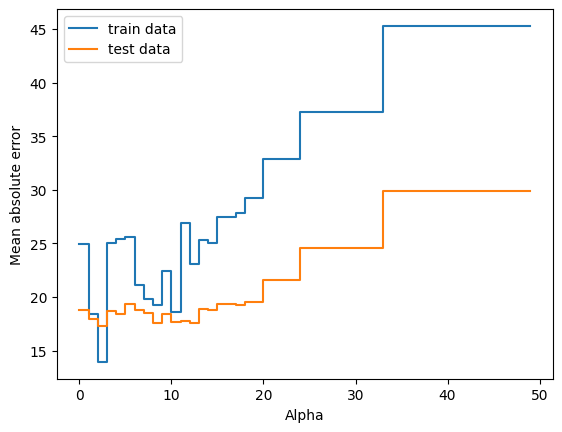

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel("Alpha")
ax.set_ylabel("Mean absolute error")

#ax.set_title("나무 복잡도 증가에 따른 오분류율 그래프")
ax.plot(alpha_list, train_scores,  label="train data", drawstyle="steps-post")
ax.plot(alpha_list, test_scores,  label="test data", drawstyle="steps-post")

#ax.plot(ccp_alpha_list, train_scores, drawstyle="steps-post")
#ax.plot(ccp_alpha_list, test_scores, drawstyle="steps-post")

ax.legend()
#plt.xlim(0.7)
plt.show()
plt.close('all')

In [ ]:
# 최적의 alpha값 도출
best_alpha = alpha_list[np.argmin(test_scores)]
print(f"최적의 alpha 값: {best_alpha}")

# 최적의 alpha값으로 최종 모델 학습
final_reg = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100,
                             learning_rate=0.4,
                             min_child_weight=10,
                             colsample_bytree=0.5,
                             max_depth=8,
                             reg_alpha=best_alpha,
                             reg_lambda=0.8,
                             eval_metric='rmse')

final_reg.fit(X_train, Y_train, eval_set=eval_set, early_stopping_rounds=20)

# 최종 모델 평가
final_preds = final_reg.predict(X_test)
print_all_reg(Y_test, final_preds)


최적의 alpha 값: 2
[0]	validation_0-rmse:31.27618
[1]	validation_0-rmse:27.97114
[2]	validation_0-rmse:31.38483
[3]	validation_0-rmse:31.58226
[4]	validation_0-rmse:32.85529
[5]	validation_0-rmse:36.84998
[6]	validation_0-rmse:37.48587
[7]	validation_0-rmse:37.95397
[8]	validation_0-rmse:39.48717
[9]	validation_0-rmse:40.19614
[10]	validation_0-rmse:41.21136
[11]	validation_0-rmse:41.93271
[12]	validation_0-rmse:43.13781
[13]	validation_0-rmse:43.88287
[14]	validation_0-rmse:44.72803
[15]	validation_0-rmse:44.49073
[16]	validation_0-rmse:45.83778
[17]	validation_0-rmse:45.47221
[18]	validation_0-rmse:45.48651
[19]	validation_0-rmse:45.81137
[20]	validation_0-rmse:46.30381


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-rmse:46.15392
model의 MSE 값은 782.385
model의 MAE 값은 21.457
model의 MAPE 값은 1.358
model의 r2 값은 0.509


### gamma에 따른 성능비교
* gain 값이 gamma 이상인 경우에만 자식 노드를 생성(트리를 분할)하도록 함

In [ ]:
# gamma 값에 따른 성능 비교
gamma_list = list(np.arange(0, 50, 1))

# 검증용 데이터셋 정의
eval_set = [(X_test, Y_test)]

train_scores = []
test_scores = []

# 모든 alpha값에 대하여 모델 적합, 최적의 alpha값 도출
for gamma in gamma_list:
    reg = xgb.XGBRegressor(objective='reg:absoluteerror',
                           n_estimators=100,
                           learning_rate=0.4,
                           min_child_weight=10,
                           colsample_bytree=0.5,
                           max_depth=8,
                          #  reg_alpha=alpha,
                           min_split_loss=gamma, # gamma를 뜻함.
                           reg_lambda=0.8,
                           eval_metric='mae')

    reg.fit(X_train, Y_train, eval_set=eval_set, early_stopping_rounds=20)

    preds_train = reg.predict(X_train)
    preds = reg.predict(X_test)

    train_scores.append(mean_absolute_error(Y_train, preds_train))  # MAE for training data
    test_scores.append(mean_absolute_error(Y_test, preds))  # MAE for testing data


[0]	validation_0-mae:23.45714
[1]	validation_0-mae:20.79571
[2]	validation_0-mae:19.64029
[3]	validation_0-mae:18.76411
[4]	validation_0-mae:19.25128
[5]	validation_0-mae:19.25068
[6]	validation_0-mae:19.26312
[7]	validation_0-mae:21.79127
[8]	validation_0-mae:21.30893
[9]	validation_0-mae:21.42269
[10]	validation_0-mae:21.57749
[11]	validation_0-mae:21.56226
[12]	validation_0-mae:21.78308
[13]	validation_0-mae:21.71888
[14]	validation_0-mae:21.48379
[15]	validation_0-mae:21.98117
[16]	validation_0-mae:21.91211
[17]	validation_0-mae:21.87230
[18]	validation_0-mae:21.89610
[19]	validation_0-mae:22.05031
[20]	validation_0-mae:22.18758
[21]	validation_0-mae:21.96393
[22]	validation_0-mae:21.76965


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:23.45714
[1]	validation_0-mae:20.84714
[2]	validation_0-mae:19.63657
[3]	validation_0-mae:18.73171
[4]	validation_0-mae:19.35295
[5]	validation_0-mae:20.18957
[6]	validation_0-mae:20.49179
[7]	validation_0-mae:20.18588
[8]	validation_0-mae:19.38225
[9]	validation_0-mae:19.63780
[10]	validation_0-mae:19.56913
[11]	validation_0-mae:19.60910
[12]	validation_0-mae:19.63546
[13]	validation_0-mae:19.61300
[14]	validation_0-mae:19.69082
[15]	validation_0-mae:20.02879
[16]	validation_0-mae:19.61875
[17]	validation_0-mae:19.63958
[18]	validation_0-mae:19.63591
[19]	validation_0-mae:19.58510
[20]	validation_0-mae:19.54056
[21]	validation_0-mae:19.55222
[22]	validation_0-mae:19.59773
[23]	validation_0-mae:19.66503


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:23.49286
[1]	validation_0-mae:20.95286
[2]	validation_0-mae:19.73972
[3]	validation_0-mae:18.48274
[4]	validation_0-mae:18.14327
[5]	validation_0-mae:17.83132
[6]	validation_0-mae:18.00757
[7]	validation_0-mae:17.70642
[8]	validation_0-mae:17.58629
[9]	validation_0-mae:17.73248
[10]	validation_0-mae:17.58714
[11]	validation_0-mae:17.53174
[12]	validation_0-mae:17.66623
[13]	validation_0-mae:18.11524
[14]	validation_0-mae:18.18613
[15]	validation_0-mae:18.77756
[16]	validation_0-mae:18.75957
[17]	validation_0-mae:18.56670
[18]	validation_0-mae:18.27645
[19]	validation_0-mae:18.17944


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-mae:18.17725
[21]	validation_0-mae:18.14098
[22]	validation_0-mae:18.13698
[23]	validation_0-mae:18.15418
[24]	validation_0-mae:18.14146
[25]	validation_0-mae:18.29404
[26]	validation_0-mae:18.31856
[27]	validation_0-mae:18.34624
[28]	validation_0-mae:18.35612
[29]	validation_0-mae:18.37582
[30]	validation_0-mae:18.37462
[31]	validation_0-mae:18.36409
[0]	validation_0-mae:23.77857
[1]	validation_0-mae:21.21429
[2]	validation_0-mae:20.43029
[3]	validation_0-mae:19.57857
[4]	validation_0-mae:20.16026
[5]	validation_0-mae:19.95920
[6]	validation_0-mae:20.43709
[7]	validation_0-mae:21.42050
[8]	validation_0-mae:21.58000
[9]	validation_0-mae:21.38523
[10]	validation_0-mae:21.29723
[11]	validation_0-mae:21.08933
[12]	validation_0-mae:22.03452
[13]	validation_0-mae:22.17953
[14]	validation_0-mae:22.26074
[15]	validation_0-mae:22.22505
[16]	validation_0-mae:22.13827
[17]	validation_0-mae:22.83680
[18]	validation_0-mae:22.67147
[19]	validation_0-mae:22.51009
[20]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:23.77857
[1]	validation_0-mae:21.21429
[2]	validation_0-mae:20.35314
[3]	validation_0-mae:19.51914
[4]	validation_0-mae:20.20549
[5]	validation_0-mae:20.67557
[6]	validation_0-mae:22.04870
[7]	validation_0-mae:23.02877
[8]	validation_0-mae:23.77463
[9]	validation_0-mae:24.10601
[10]	validation_0-mae:24.13339
[11]	validation_0-mae:25.44426
[12]	validation_0-mae:25.16992
[13]	validation_0-mae:25.45121
[14]	validation_0-mae:24.93318
[15]	validation_0-mae:24.77973
[16]	validation_0-mae:24.43511
[17]	validation_0-mae:23.46578
[18]	validation_0-mae:23.38080
[19]	validation_0-mae:23.29866
[20]	validation_0-mae:23.13560
[21]	validation_0-mae:23.07792
[22]	validation_0-mae:23.03227


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:23.77857
[1]	validation_0-mae:19.61286
[2]	validation_0-mae:18.24771
[3]	validation_0-mae:18.28474
[4]	validation_0-mae:18.72066
[5]	validation_0-mae:18.03306
[6]	validation_0-mae:17.89118
[7]	validation_0-mae:18.36992
[8]	validation_0-mae:18.56747
[9]	validation_0-mae:18.17373
[10]	validation_0-mae:17.22665
[11]	validation_0-mae:17.71361
[12]	validation_0-mae:17.56355
[13]	validation_0-mae:17.72537
[14]	validation_0-mae:17.68572
[15]	validation_0-mae:17.55752
[16]	validation_0-mae:18.76043
[17]	validation_0-mae:18.82786
[18]	validation_0-mae:18.88494
[19]	validation_0-mae:19.48598
[20]	validation_0-mae:19.57033
[21]	validation_0-mae:19.58340
[22]	validation_0-mae:19.70552


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[23]	validation_0-mae:19.70663
[24]	validation_0-mae:19.85477
[25]	validation_0-mae:19.84776
[26]	validation_0-mae:19.83115
[27]	validation_0-mae:19.86890
[28]	validation_0-mae:19.76454
[29]	validation_0-mae:19.82200
[0]	validation_0-mae:23.77857
[1]	validation_0-mae:19.61286
[2]	validation_0-mae:18.24771
[3]	validation_0-mae:18.10474
[4]	validation_0-mae:18.83112
[5]	validation_0-mae:20.07748
[6]	validation_0-mae:20.24894
[7]	validation_0-mae:20.11543
[8]	validation_0-mae:20.09050
[9]	validation_0-mae:19.84848
[10]	validation_0-mae:19.62200
[11]	validation_0-mae:19.77924
[12]	validation_0-mae:19.66843
[13]	validation_0-mae:19.85063


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[14]	validation_0-mae:20.01904
[15]	validation_0-mae:20.01725
[16]	validation_0-mae:19.99185
[17]	validation_0-mae:19.99707
[18]	validation_0-mae:20.10714
[19]	validation_0-mae:20.08037
[20]	validation_0-mae:20.92614
[21]	validation_0-mae:20.63209
[22]	validation_0-mae:21.01454
[23]	validation_0-mae:20.98691
[0]	validation_0-mae:24.27857


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-mae:20.72000
[2]	validation_0-mae:18.67657
[3]	validation_0-mae:18.02651
[4]	validation_0-mae:18.32027
[5]	validation_0-mae:18.91170
[6]	validation_0-mae:18.81997
[7]	validation_0-mae:18.82196
[8]	validation_0-mae:18.79565
[9]	validation_0-mae:18.77986
[10]	validation_0-mae:18.50314
[11]	validation_0-mae:18.50320
[12]	validation_0-mae:18.46673
[13]	validation_0-mae:18.70663
[14]	validation_0-mae:18.69888
[15]	validation_0-mae:18.69423
[16]	validation_0-mae:18.69144
[17]	validation_0-mae:18.68977
[18]	validation_0-mae:18.68876
[19]	validation_0-mae:18.68816
[20]	validation_0-mae:18.68780
[21]	validation_0-mae:18.68758
[22]	validation_0-mae:18.68745
[23]	validation_0-mae:18.68737
[0]	validation_0-mae:24.39286
[1]	validation_0-mae:20.78857
[2]	validation_0-mae:19.42000
[3]	validation_0-mae:19.25269
[4]	validation_0-mae:19.23687
[5]	validation_0-mae:19.10852


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-mae:19.67808
[7]	validation_0-mae:19.40802
[8]	validation_0-mae:19.31045
[9]	validation_0-mae:19.25190
[10]	validation_0-mae:19.21677
[11]	validation_0-mae:19.19570
[12]	validation_0-mae:19.18305
[13]	validation_0-mae:19.17546
[14]	validation_0-mae:19.17091
[15]	validation_0-mae:19.16818
[16]	validation_0-mae:19.16654
[17]	validation_0-mae:19.16556
[18]	validation_0-mae:19.16497
[19]	validation_0-mae:19.16461
[20]	validation_0-mae:19.16440
[21]	validation_0-mae:19.16427
[22]	validation_0-mae:19.16420
[23]	validation_0-mae:19.16415
[24]	validation_0-mae:19.16412
[25]	validation_0-mae:19.16411
[0]	validation_0-mae:24.39286
[1]	validation_0-mae:20.68857
[2]	validation_0-mae:18.90371
[3]	validation_0-mae:18.81091
[4]	validation_0-mae:18.20019
[5]	validation_0-mae:18.03408
[6]	validation_0-mae:17.97402


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-mae:18.10238
[8]	validation_0-mae:17.99654
[9]	validation_0-mae:17.96470
[10]	validation_0-mae:17.97231
[11]	validation_0-mae:17.97688
[12]	validation_0-mae:17.97962
[13]	validation_0-mae:17.98126
[14]	validation_0-mae:17.98225
[15]	validation_0-mae:17.98284
[16]	validation_0-mae:17.98320
[17]	validation_0-mae:17.98341
[18]	validation_0-mae:17.98354
[19]	validation_0-mae:17.98361
[20]	validation_0-mae:17.98366
[21]	validation_0-mae:17.98369
[22]	validation_0-mae:17.98370
[23]	validation_0-mae:17.98371
[24]	validation_0-mae:17.98372
[25]	validation_0-mae:17.98372
[26]	validation_0-mae:17.98372
[27]	validation_0-mae:17.98373
[28]	validation_0-mae:17.98373
[29]	validation_0-mae:17.98373
[0]	validation_0-mae:24.39286
[1]	validation_0-mae:20.68857
[2]	validation_0-mae:18.90371
[3]	validation_0-mae:18.81091
[4]	validation_0-mae:18.81238
[5]	validation_0-mae:18.78468


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-mae:18.79092
[7]	validation_0-mae:18.94378
[8]	validation_0-mae:19.01223
[9]	validation_0-mae:19.06134
[10]	validation_0-mae:19.09420
[11]	validation_0-mae:19.11391
[12]	validation_0-mae:19.12574
[13]	validation_0-mae:19.13284
[14]	validation_0-mae:19.13710
[15]	validation_0-mae:19.13965
[16]	validation_0-mae:19.14118
[17]	validation_0-mae:19.14210
[18]	validation_0-mae:19.14266
[19]	validation_0-mae:19.14299
[20]	validation_0-mae:19.14319
[21]	validation_0-mae:19.14330
[22]	validation_0-mae:19.14338
[23]	validation_0-mae:19.14342
[24]	validation_0-mae:19.14345
[0]	validation_0-mae:24.39286
[1]	validation_0-mae:20.68857
[2]	validation_0-mae:18.90371
[3]	validation_0-mae:18.81091
[4]	validation_0-mae:18.81238
[5]	validation_0-mae:18.78468
[6]	validation_0-mae:18.79092


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-mae:18.79467
[8]	validation_0-mae:18.79692
[9]	validation_0-mae:18.79826
[10]	validation_0-mae:18.41214
[11]	validation_0-mae:18.36694
[12]	validation_0-mae:18.33982
[13]	validation_0-mae:18.32355
[14]	validation_0-mae:18.31379
[15]	validation_0-mae:18.15607
[16]	validation_0-mae:18.08607
[17]	validation_0-mae:18.04406
[18]	validation_0-mae:18.01886
[19]	validation_0-mae:18.00374
[20]	validation_0-mae:17.99467
[21]	validation_0-mae:17.98923
[22]	validation_0-mae:17.98596
[23]	validation_0-mae:17.98400
[24]	validation_0-mae:17.98282
[25]	validation_0-mae:17.98212
[26]	validation_0-mae:17.98169
[27]	validation_0-mae:17.98144
[28]	validation_0-mae:17.98129
[29]	validation_0-mae:17.98120
[30]	validation_0-mae:17.98114
[31]	validation_0-mae:17.98111
[32]	validation_0-mae:17.98109
[33]	validation_0-mae:17.98108
[34]	validation_0-mae:17.98107
[35]	validation_0-mae:17.98107
[36]	validation_0-mae:17.98106
[37]	validation_0-mae:17.98106
[38]	validation_0-mae:17.98106
[39]	valida

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[9]	validation_0-mae:18.88791
[10]	validation_0-mae:18.88285
[11]	validation_0-mae:18.87981
[12]	validation_0-mae:18.87799
[13]	validation_0-mae:18.87690
[14]	validation_0-mae:18.87624
[15]	validation_0-mae:18.87585
[16]	validation_0-mae:18.87561
[17]	validation_0-mae:18.87547
[18]	validation_0-mae:18.87538
[19]	validation_0-mae:18.87533
[20]	validation_0-mae:18.87530
[21]	validation_0-mae:18.87528
[22]	validation_0-mae:18.87527
[23]	validation_0-mae:18.87527
[24]	validation_0-mae:18.87526
[0]	validation_0-mae:24.39286
[1]	validation_0-mae:20.68857
[2]	validation_0-mae:18.90371
[3]	validation_0-mae:18.93069
[4]	validation_0-mae:18.94687


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-mae:18.95658
[6]	validation_0-mae:18.96240
[7]	validation_0-mae:18.96590
[8]	validation_0-mae:18.96800
[9]	validation_0-mae:18.96926
[10]	validation_0-mae:18.97001
[11]	validation_0-mae:18.97046
[12]	validation_0-mae:18.97074
[13]	validation_0-mae:18.97090
[14]	validation_0-mae:18.97100
[15]	validation_0-mae:18.97105
[16]	validation_0-mae:18.97109
[17]	validation_0-mae:18.97111
[18]	validation_0-mae:18.97112
[19]	validation_0-mae:18.97113
[20]	validation_0-mae:18.97114
[21]	validation_0-mae:18.97114
[0]	validation_0-mae:24.39286
[1]	validation_0-mae:20.68857
[2]	validation_0-mae:18.90371
[3]	validation_0-mae:18.93069
[4]	validation_0-mae:18.94687
[5]	validation_0-mae:18.95658
[6]	validation_0-mae:18.96240
[7]	validation_0-mae:18.96590
[8]	validation_0-mae:18.96800
[9]	validation_0-mae:18.96926
[10]	validation_0-mae:18.97001
[11]	validation_0-mae:18.97046
[12]	validation_0-mae:18.97074
[13]	validation_0-mae:18.97090
[14]	validation_0-mae:18.97100
[15]	validation_0-mae:1

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[18]	validation_0-mae:18.97112
[19]	validation_0-mae:18.97113
[20]	validation_0-mae:18.97114
[21]	validation_0-mae:18.97114
[0]	validation_0-mae:24.39286
[1]	validation_0-mae:20.68857
[2]	validation_0-mae:18.90371
[3]	validation_0-mae:18.93069
[4]	validation_0-mae:18.94687
[5]	validation_0-mae:18.95658
[6]	validation_0-mae:18.96240
[7]	validation_0-mae:18.96590
[8]	validation_0-mae:18.96800
[9]	validation_0-mae:18.96926
[10]	validation_0-mae:18.97001
[11]	validation_0-mae:18.97046
[12]	validation_0-mae:18.97074
[13]	validation_0-mae:18.97090
[14]	validation_0-mae:18.97100
[15]	validation_0-mae:18.97105
[16]	validation_0-mae:18.97109
[17]	validation_0-mae:18.97111
[18]	validation_0-mae:18.97112
[19]	validation_0-mae:18.97113
[20]	validation_0-mae:18.97114
[21]	validation_0-mae:18.97114


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:24.39286
[1]	validation_0-mae:20.68857
[2]	validation_0-mae:18.90371
[3]	validation_0-mae:18.93069
[4]	validation_0-mae:18.94687
[5]	validation_0-mae:18.95658
[6]	validation_0-mae:18.96240
[7]	validation_0-mae:18.96590
[8]	validation_0-mae:18.96800
[9]	validation_0-mae:18.96926
[10]	validation_0-mae:18.97001
[11]	validation_0-mae:18.97046
[12]	validation_0-mae:18.97074
[13]	validation_0-mae:18.97090
[14]	validation_0-mae:18.97100
[15]	validation_0-mae:18.97105
[16]	validation_0-mae:18.97109
[17]	validation_0-mae:18.97111
[18]	validation_0-mae:18.97112
[19]	validation_0-mae:18.97113
[20]	validation_0-mae:18.97114


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-mae:18.97114
[22]	validation_0-mae:18.97114
[0]	validation_0-mae:24.39286
[1]	validation_0-mae:20.68857
[2]	validation_0-mae:18.90371
[3]	validation_0-mae:18.93069
[4]	validation_0-mae:18.94687
[5]	validation_0-mae:18.95658
[6]	validation_0-mae:18.96240
[7]	validation_0-mae:18.96590
[8]	validation_0-mae:18.96800
[9]	validation_0-mae:18.96926
[10]	validation_0-mae:18.97001
[11]	validation_0-mae:18.97046
[12]	validation_0-mae:18.97074
[13]	validation_0-mae:18.97090
[14]	validation_0-mae:18.97100
[15]	validation_0-mae:18.97105
[16]	validation_0-mae:18.97109
[17]	validation_0-mae:18.97111
[18]	validation_0-mae:18.97112


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[19]	validation_0-mae:18.97113
[20]	validation_0-mae:18.97114
[21]	validation_0-mae:18.97114
[22]	validation_0-mae:18.97114
[0]	validation_0-mae:24.39286
[1]	validation_0-mae:20.68857
[2]	validation_0-mae:18.90371
[3]	validation_0-mae:18.93069
[4]	validation_0-mae:18.94687
[5]	validation_0-mae:18.95658
[6]	validation_0-mae:18.96240
[7]	validation_0-mae:18.96590
[8]	validation_0-mae:18.96800
[9]	validation_0-mae:18.96926
[10]	validation_0-mae:18.97001
[11]	validation_0-mae:18.97046
[12]	validation_0-mae:18.97074
[13]	validation_0-mae:18.97090
[14]	validation_0-mae:18.97100
[15]	validation_0-mae:18.97105
[16]	validation_0-mae:18.97109
[17]	validation_0-mae:18.97111
[18]	validation_0-mae:18.97112


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[19]	validation_0-mae:18.97113
[20]	validation_0-mae:18.97114
[21]	validation_0-mae:18.97114
[22]	validation_0-mae:18.97114
[0]	validation_0-mae:24.39286
[1]	validation_0-mae:20.68857
[2]	validation_0-mae:18.90371
[3]	validation_0-mae:18.93069
[4]	validation_0-mae:18.94687
[5]	validation_0-mae:18.95658
[6]	validation_0-mae:18.96240
[7]	validation_0-mae:18.96590
[8]	validation_0-mae:18.96800
[9]	validation_0-mae:18.96926
[10]	validation_0-mae:18.97001
[11]	validation_0-mae:18.97046
[12]	validation_0-mae:18.97074
[13]	validation_0-mae:18.97090
[14]	validation_0-mae:18.97100
[15]	validation_0-mae:18.97105
[16]	validation_0-mae:18.97109
[17]	validation_0-mae:18.97111
[18]	validation_0-mae:18.97112
[19]	validation_0-mae:18.97113
[20]	validation_0-mae:18.97114
[21]	validation_0-mae:18.97114


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:24.39286
[1]	validation_0-mae:20.68857
[2]	validation_0-mae:18.90371
[3]	validation_0-mae:18.93069
[4]	validation_0-mae:18.94687
[5]	validation_0-mae:18.95658
[6]	validation_0-mae:18.96240
[7]	validation_0-mae:18.96590
[8]	validation_0-mae:18.96800
[9]	validation_0-mae:18.96926
[10]	validation_0-mae:18.97001
[11]	validation_0-mae:18.97046
[12]	validation_0-mae:18.97074
[13]	validation_0-mae:18.97090
[14]	validation_0-mae:18.97100
[15]	validation_0-mae:18.97105
[16]	validation_0-mae:18.97109


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-mae:18.97111
[18]	validation_0-mae:18.97112
[19]	validation_0-mae:18.97113
[20]	validation_0-mae:18.97114
[21]	validation_0-mae:18.97114
[22]	validation_0-mae:18.97114
[0]	validation_0-mae:24.39286
[1]	validation_0-mae:20.68857
[2]	validation_0-mae:20.63600
[3]	validation_0-mae:20.60446
[4]	validation_0-mae:20.58553
[5]	validation_0-mae:20.57417
[6]	validation_0-mae:20.56736
[7]	validation_0-mae:20.56327
[8]	validation_0-mae:20.56082
[9]	validation_0-mae:20.55935
[10]	validation_0-mae:20.55847
[11]	validation_0-mae:20.55794
[12]	validation_0-mae:20.55762
[13]	validation_0-mae:20.55743
[14]	validation_0-mae:20.55731
[15]	validation_0-mae:20.55725
[16]	validation_0-mae:20.55720
[17]	validation_0-mae:20.55718


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[18]	validation_0-mae:20.55716
[19]	validation_0-mae:20.55715
[20]	validation_0-mae:20.55715
[21]	validation_0-mae:20.55715
[22]	validation_0-mae:20.55714
[23]	validation_0-mae:20.55714
[24]	validation_0-mae:20.55714
[25]	validation_0-mae:20.55714
[26]	validation_0-mae:20.55714
[27]	validation_0-mae:20.55714
[28]	validation_0-mae:20.55714
[29]	validation_0-mae:20.55714
[30]	validation_0-mae:20.55714
[31]	validation_0-mae:20.55714
[32]	validation_0-mae:20.55714
[33]	validation_0-mae:20.55714
[34]	validation_0-mae:20.55714
[35]	validation_0-mae:20.55714
[36]	validation_0-mae:20.55714
[37]	validation_0-mae:20.55714
[38]	validation_0-mae:20.55714
[39]	validation_0-mae:20.55714
[40]	validation_0-mae:20.55714
[41]	validation_0-mae:20.55714
[42]	validation_0-mae:20.55714
[43]	validation_0-mae:20.55714
[0]	validation_0-mae:24.39286
[1]	validation_0-mae:20.68857
[2]	validation_0-mae:20.63600
[3]	validation_0-mae:20.60446
[4]	validation_0-mae:20.58553
[5]	validation_0-mae:20.57417
[6]	validation

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-mae:20.55715
[22]	validation_0-mae:20.55714
[23]	validation_0-mae:20.55714
[24]	validation_0-mae:20.55714
[25]	validation_0-mae:20.55714
[26]	validation_0-mae:20.55714
[27]	validation_0-mae:20.55714
[28]	validation_0-mae:20.55714
[29]	validation_0-mae:20.55714
[30]	validation_0-mae:20.55714
[31]	validation_0-mae:20.55714
[32]	validation_0-mae:20.55714
[33]	validation_0-mae:20.55714
[34]	validation_0-mae:20.55714
[35]	validation_0-mae:20.55714
[36]	validation_0-mae:20.55714
[37]	validation_0-mae:20.55714
[38]	validation_0-mae:20.55714
[39]	validation_0-mae:20.55714
[40]	validation_0-mae:20.55714
[41]	validation_0-mae:20.55714
[42]	validation_0-mae:20.55714
[43]	validation_0-mae:20.55714
[0]	validation_0-mae:24.39286
[1]	validation_0-mae:20.68857
[2]	validation_0-mae:20.63600
[3]	validation_0-mae:20.60446
[4]	validation_0-mae:20.58553
[5]	validation_0-mae:20.57417
[6]	validation_0-mae:20.56736
[7]	validation_0-mae:20.56327
[8]	validation_0-mae:20.56082
[9]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-mae:20.55714
[28]	validation_0-mae:20.55714
[29]	validation_0-mae:20.55714
[30]	validation_0-mae:20.55714
[31]	validation_0-mae:20.55714
[32]	validation_0-mae:20.55714
[33]	validation_0-mae:20.55714
[34]	validation_0-mae:20.55714
[35]	validation_0-mae:20.55714
[36]	validation_0-mae:20.55714
[37]	validation_0-mae:20.55714
[38]	validation_0-mae:20.55714
[39]	validation_0-mae:20.55714
[40]	validation_0-mae:20.55714
[41]	validation_0-mae:20.55714
[42]	validation_0-mae:20.55714
[43]	validation_0-mae:20.55714
[44]	validation_0-mae:20.55714
[0]	validation_0-mae:24.39286
[1]	validation_0-mae:24.39286
[2]	validation_0-mae:24.39286
[3]	validation_0-mae:24.39286
[4]	validation_0-mae:24.39286
[5]	validation_0-mae:24.39286
[6]	validation_0-mae:24.39286
[7]	validation_0-mae:24.39286
[8]	validation_0-mae:24.39286
[9]	validation_0-mae:24.39286
[10]	validation_0-mae:24.39286
[11]	validation_0-mae:24.39286
[12]	validation_0-mae:24.39286
[13]	validation_0-mae:24.39286
[14]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-mae:24.39286
[18]	validation_0-mae:24.39286
[19]	validation_0-mae:24.39286
[20]	validation_0-mae:24.39286
[21]	validation_0-mae:24.39286
[22]	validation_0-mae:24.39286
[23]	validation_0-mae:24.39286
[24]	validation_0-mae:24.39286
[25]	validation_0-mae:24.39286
[26]	validation_0-mae:24.39286
[27]	validation_0-mae:24.39286
[28]	validation_0-mae:24.39286
[0]	validation_0-mae:24.39286
[1]	validation_0-mae:24.39286
[2]	validation_0-mae:24.39286
[3]	validation_0-mae:24.39286
[4]	validation_0-mae:24.39286
[5]	validation_0-mae:24.39286
[6]	validation_0-mae:24.39286
[7]	validation_0-mae:24.39286
[8]	validation_0-mae:24.39286
[9]	validation_0-mae:24.39286
[10]	validation_0-mae:24.39286
[11]	validation_0-mae:24.39286
[12]	validation_0-mae:24.39286
[13]	validation_0-mae:24.39286
[14]	validation_0-mae:24.39286
[15]	validation_0-mae:24.39286
[16]	validation_0-mae:24.39286
[17]	validation_0-mae:24.39286


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[18]	validation_0-mae:24.39286
[19]	validation_0-mae:24.39286
[20]	validation_0-mae:24.39286
[21]	validation_0-mae:24.39286
[22]	validation_0-mae:24.39286
[23]	validation_0-mae:24.39286
[24]	validation_0-mae:24.39286
[25]	validation_0-mae:24.39286
[26]	validation_0-mae:24.39286
[27]	validation_0-mae:24.39286
[28]	validation_0-mae:24.39286
[0]	validation_0-mae:24.39286
[1]	validation_0-mae:24.39286
[2]	validation_0-mae:24.39286
[3]	validation_0-mae:24.39286
[4]	validation_0-mae:24.39286
[5]	validation_0-mae:24.39286
[6]	validation_0-mae:24.39286
[7]	validation_0-mae:24.39286
[8]	validation_0-mae:24.39286
[9]	validation_0-mae:24.39286
[10]	validation_0-mae:24.39286
[11]	validation_0-mae:24.39286
[12]	validation_0-mae:24.39286
[13]	validation_0-mae:24.39286
[14]	validation_0-mae:24.39286
[15]	validation_0-mae:24.39286
[16]	validation_0-mae:24.39286


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-mae:24.39286
[18]	validation_0-mae:24.39286
[19]	validation_0-mae:24.39286
[20]	validation_0-mae:24.39286
[21]	validation_0-mae:24.39286
[22]	validation_0-mae:24.39286
[23]	validation_0-mae:24.39286
[24]	validation_0-mae:24.39286
[25]	validation_0-mae:24.39286
[26]	validation_0-mae:24.39286
[27]	validation_0-mae:24.39286
[28]	validation_0-mae:24.39286
[29]	validation_0-mae:24.39286
[0]	validation_0-mae:24.39286
[1]	validation_0-mae:24.39286
[2]	validation_0-mae:24.39286
[3]	validation_0-mae:24.39286
[4]	validation_0-mae:24.39286
[5]	validation_0-mae:24.39286
[6]	validation_0-mae:24.39286
[7]	validation_0-mae:24.39286
[8]	validation_0-mae:24.39286
[9]	validation_0-mae:24.39286
[10]	validation_0-mae:24.39286
[11]	validation_0-mae:24.39286
[12]	validation_0-mae:24.39286
[13]	validation_0-mae:24.39286
[14]	validation_0-mae:24.39286
[15]	validation_0-mae:24.39286
[16]	validation_0-mae:24.39286
[17]	validation_0-mae:24.39286
[18]	validation_0-mae:24.39286
[19]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-mae:24.39286
[22]	validation_0-mae:24.39286
[23]	validation_0-mae:24.39286
[24]	validation_0-mae:24.39286
[25]	validation_0-mae:24.39286
[26]	validation_0-mae:24.39286
[27]	validation_0-mae:24.39286
[28]	validation_0-mae:24.39286
[0]	validation_0-mae:24.39286
[1]	validation_0-mae:24.39286
[2]	validation_0-mae:24.39286
[3]	validation_0-mae:24.39286
[4]	validation_0-mae:24.39286
[5]	validation_0-mae:24.39286
[6]	validation_0-mae:24.39286
[7]	validation_0-mae:24.39286
[8]	validation_0-mae:24.39286
[9]	validation_0-mae:24.39286
[10]	validation_0-mae:24.39286
[11]	validation_0-mae:24.39286
[12]	validation_0-mae:24.39286
[13]	validation_0-mae:24.39286
[14]	validation_0-mae:24.39286
[15]	validation_0-mae:24.39286
[16]	validation_0-mae:24.39286
[17]	validation_0-mae:24.39286
[18]	validation_0-mae:24.39286
[19]	validation_0-mae:24.39286
[20]	validation_0-mae:24.39286
[21]	validation_0-mae:24.39286
[22]	validation_0-mae:24.39286
[23]	validation_0-mae:24.39286
[24]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:24.39286
[1]	validation_0-mae:24.39286
[2]	validation_0-mae:24.39286
[3]	validation_0-mae:24.39286
[4]	validation_0-mae:24.39286
[5]	validation_0-mae:24.39286
[6]	validation_0-mae:24.39286
[7]	validation_0-mae:24.39286
[8]	validation_0-mae:24.39286
[9]	validation_0-mae:24.39286
[10]	validation_0-mae:24.39286
[11]	validation_0-mae:24.39286
[12]	validation_0-mae:24.39286
[13]	validation_0-mae:24.39286
[14]	validation_0-mae:24.39286
[15]	validation_0-mae:24.39286
[16]	validation_0-mae:24.39286
[17]	validation_0-mae:24.39286
[18]	validation_0-mae:24.39286
[19]	validation_0-mae:24.39286
[20]	validation_0-mae:24.39286
[21]	validation_0-mae:24.39286
[22]	validation_0-mae:24.39286
[23]	validation_0-mae:24.39286
[24]	validation_0-mae:24.39286
[25]	validation_0-mae:24.39286
[26]	validation_0-mae:24.39286
[27]	validation_0-mae:24.39286


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-mae:24.39286
[0]	validation_0-mae:24.39286
[1]	validation_0-mae:24.39286
[2]	validation_0-mae:24.39286
[3]	validation_0-mae:24.39286
[4]	validation_0-mae:24.39286
[5]	validation_0-mae:24.39286
[6]	validation_0-mae:24.39286
[7]	validation_0-mae:24.39286
[8]	validation_0-mae:24.39286
[9]	validation_0-mae:24.39286
[10]	validation_0-mae:24.39286
[11]	validation_0-mae:24.39286
[12]	validation_0-mae:24.39286
[13]	validation_0-mae:24.39286
[14]	validation_0-mae:24.39286
[15]	validation_0-mae:24.39286
[16]	validation_0-mae:24.39286
[17]	validation_0-mae:24.39286
[18]	validation_0-mae:24.39286
[19]	validation_0-mae:24.39286
[20]	validation_0-mae:24.39286
[21]	validation_0-mae:24.39286
[22]	validation_0-mae:24.39286
[23]	validation_0-mae:24.39286
[24]	validation_0-mae:24.39286
[25]	validation_0-mae:24.39286
[26]	validation_0-mae:24.39286
[27]	validation_0-mae:24.39286


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-mae:24.39286
[0]	validation_0-mae:24.39286
[1]	validation_0-mae:24.39286
[2]	validation_0-mae:24.39286
[3]	validation_0-mae:24.39286
[4]	validation_0-mae:24.39286
[5]	validation_0-mae:24.39286
[6]	validation_0-mae:24.39286
[7]	validation_0-mae:24.39286
[8]	validation_0-mae:24.39286
[9]	validation_0-mae:24.39286
[10]	validation_0-mae:24.39286
[11]	validation_0-mae:24.39286
[12]	validation_0-mae:24.39286
[13]	validation_0-mae:24.39286
[14]	validation_0-mae:24.39286
[15]	validation_0-mae:24.39286
[16]	validation_0-mae:24.39286
[17]	validation_0-mae:24.39286
[18]	validation_0-mae:24.39286
[19]	validation_0-mae:24.39286
[20]	validation_0-mae:24.39286


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-mae:24.39286
[22]	validation_0-mae:24.39286
[23]	validation_0-mae:24.39286
[24]	validation_0-mae:24.39286
[25]	validation_0-mae:24.39286
[26]	validation_0-mae:24.39286
[27]	validation_0-mae:24.39286
[28]	validation_0-mae:24.39286
[0]	validation_0-mae:24.39286
[1]	validation_0-mae:24.39286
[2]	validation_0-mae:24.39286
[3]	validation_0-mae:24.39286
[4]	validation_0-mae:24.39286
[5]	validation_0-mae:24.39286
[6]	validation_0-mae:24.39286
[7]	validation_0-mae:24.39286
[8]	validation_0-mae:24.39286
[9]	validation_0-mae:24.39286
[10]	validation_0-mae:24.39286
[11]	validation_0-mae:24.39286
[12]	validation_0-mae:24.39286
[13]	validation_0-mae:24.39286
[14]	validation_0-mae:24.39286
[15]	validation_0-mae:24.39286
[16]	validation_0-mae:24.39286
[17]	validation_0-mae:24.39286
[18]	validation_0-mae:24.39286
[19]	validation_0-mae:24.39286
[20]	validation_0-mae:24.39286
[21]	validation_0-mae:24.39286
[22]	validation_0-mae:24.39286
[23]	validation_0-mae:24.39286
[24]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[25]	validation_0-mae:24.39286
[26]	validation_0-mae:24.39286
[27]	validation_0-mae:24.39286
[28]	validation_0-mae:24.39286
[29]	validation_0-mae:24.39286
[0]	validation_0-mae:24.39286
[1]	validation_0-mae:24.39286
[2]	validation_0-mae:24.39286
[3]	validation_0-mae:24.39286
[4]	validation_0-mae:24.39286
[5]	validation_0-mae:24.39286
[6]	validation_0-mae:24.39286
[7]	validation_0-mae:24.39286
[8]	validation_0-mae:24.39286
[9]	validation_0-mae:24.39286
[10]	validation_0-mae:24.39286
[11]	validation_0-mae:24.39286
[12]	validation_0-mae:24.39286
[13]	validation_0-mae:24.39286
[14]	validation_0-mae:24.39286
[15]	validation_0-mae:24.39286
[16]	validation_0-mae:24.39286
[17]	validation_0-mae:24.39286
[18]	validation_0-mae:24.39286
[19]	validation_0-mae:24.39286
[20]	validation_0-mae:24.39286
[21]	validation_0-mae:24.39286
[22]	validation_0-mae:24.39286
[23]	validation_0-mae:24.39286
[24]	validation_0-mae:24.39286


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[25]	validation_0-mae:24.39286
[26]	validation_0-mae:24.39286
[27]	validation_0-mae:24.39286
[28]	validation_0-mae:24.39286
[29]	validation_0-mae:24.39286
[0]	validation_0-mae:24.39286
[1]	validation_0-mae:24.39286
[2]	validation_0-mae:24.39286
[3]	validation_0-mae:24.39286
[4]	validation_0-mae:24.39286
[5]	validation_0-mae:24.39286
[6]	validation_0-mae:24.39286
[7]	validation_0-mae:24.39286
[8]	validation_0-mae:24.39286
[9]	validation_0-mae:24.39286
[10]	validation_0-mae:24.39286
[11]	validation_0-mae:24.39286
[12]	validation_0-mae:24.39286
[13]	validation_0-mae:24.39286
[14]	validation_0-mae:24.39286
[15]	validation_0-mae:24.39286
[16]	validation_0-mae:24.39286
[17]	validation_0-mae:24.39286
[18]	validation_0-mae:24.39286
[19]	validation_0-mae:24.39286
[20]	validation_0-mae:24.39286
[21]	validation_0-mae:24.39286


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22]	validation_0-mae:24.39286
[23]	validation_0-mae:24.39286
[24]	validation_0-mae:24.39286
[25]	validation_0-mae:24.39286
[26]	validation_0-mae:24.39286
[27]	validation_0-mae:24.39286
[28]	validation_0-mae:24.39286
[0]	validation_0-mae:24.39286
[1]	validation_0-mae:24.39286
[2]	validation_0-mae:24.39286
[3]	validation_0-mae:24.39286
[4]	validation_0-mae:24.39286
[5]	validation_0-mae:24.39286
[6]	validation_0-mae:24.39286
[7]	validation_0-mae:24.39286
[8]	validation_0-mae:24.39286
[9]	validation_0-mae:24.39286
[10]	validation_0-mae:24.39286
[11]	validation_0-mae:24.39286
[12]	validation_0-mae:24.39286
[13]	validation_0-mae:24.39286
[14]	validation_0-mae:24.39286
[15]	validation_0-mae:24.39286
[16]	validation_0-mae:24.39286
[17]	validation_0-mae:24.39286
[18]	validation_0-mae:24.39286
[19]	validation_0-mae:24.39286
[20]	validation_0-mae:24.39286
[21]	validation_0-mae:24.39286
[22]	validation_0-mae:24.39286


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[23]	validation_0-mae:24.39286
[24]	validation_0-mae:24.39286
[25]	validation_0-mae:24.39286
[26]	validation_0-mae:24.39286
[27]	validation_0-mae:24.39286
[28]	validation_0-mae:24.39286
[0]	validation_0-mae:24.39286
[1]	validation_0-mae:24.39286
[2]	validation_0-mae:24.39286
[3]	validation_0-mae:24.39286
[4]	validation_0-mae:24.39286
[5]	validation_0-mae:24.39286
[6]	validation_0-mae:24.39286
[7]	validation_0-mae:24.39286
[8]	validation_0-mae:24.39286
[9]	validation_0-mae:24.39286
[10]	validation_0-mae:24.39286
[11]	validation_0-mae:24.39286
[12]	validation_0-mae:24.39286
[13]	validation_0-mae:24.39286
[14]	validation_0-mae:24.39286
[15]	validation_0-mae:24.39286
[16]	validation_0-mae:24.39286
[17]	validation_0-mae:24.39286
[18]	validation_0-mae:24.39286
[19]	validation_0-mae:24.39286
[20]	validation_0-mae:24.39286
[21]	validation_0-mae:24.39286
[22]	validation_0-mae:24.39286
[23]	validation_0-mae:24.39286
[24]	validation_0-mae:24.39286
[25]	validation_0-mae:24.39286


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[26]	validation_0-mae:24.39286
[27]	validation_0-mae:24.39286
[28]	validation_0-mae:24.39286
[0]	validation_0-mae:24.39286
[1]	validation_0-mae:24.39286
[2]	validation_0-mae:24.39286
[3]	validation_0-mae:24.39286
[4]	validation_0-mae:24.39286
[5]	validation_0-mae:24.39286
[6]	validation_0-mae:24.39286
[7]	validation_0-mae:24.39286
[8]	validation_0-mae:24.39286
[9]	validation_0-mae:24.39286
[10]	validation_0-mae:24.39286
[11]	validation_0-mae:24.39286
[12]	validation_0-mae:24.39286
[13]	validation_0-mae:24.39286
[14]	validation_0-mae:24.39286
[15]	validation_0-mae:24.39286
[16]	validation_0-mae:24.39286
[17]	validation_0-mae:24.39286


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[18]	validation_0-mae:24.39286
[19]	validation_0-mae:24.39286
[20]	validation_0-mae:24.39286
[21]	validation_0-mae:24.39286
[22]	validation_0-mae:24.39286
[23]	validation_0-mae:24.39286
[24]	validation_0-mae:24.39286
[25]	validation_0-mae:24.39286
[26]	validation_0-mae:24.39286
[27]	validation_0-mae:24.39286
[28]	validation_0-mae:24.39286


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:24.39286
[1]	validation_0-mae:24.39286
[2]	validation_0-mae:24.39286
[3]	validation_0-mae:24.39286
[4]	validation_0-mae:24.39286
[5]	validation_0-mae:24.39286
[6]	validation_0-mae:24.39286
[7]	validation_0-mae:24.39286
[8]	validation_0-mae:24.39286
[9]	validation_0-mae:24.39286
[10]	validation_0-mae:24.39286
[11]	validation_0-mae:24.39286
[12]	validation_0-mae:24.39286
[13]	validation_0-mae:24.39286
[14]	validation_0-mae:24.39286
[15]	validation_0-mae:24.39286
[16]	validation_0-mae:24.39286
[17]	validation_0-mae:24.39286
[18]	validation_0-mae:24.39286
[19]	validation_0-mae:24.39286
[20]	validation_0-mae:24.39286
[21]	validation_0-mae:24.39286
[22]	validation_0-mae:24.39286
[23]	validation_0-mae:24.39286
[24]	validation_0-mae:24.39286
[25]	validation_0-mae:24.39286
[26]	validation_0-mae:24.39286
[27]	validation_0-mae:24.39286
[28]	validation_0-mae:24.39286
[29]	validation_0-mae:24.39286
[0]	validation_0-mae:24.39286
[1]	validation_0-mae:24.39286
[2]	validation_0-mae

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[13]	validation_0-mae:24.39286
[14]	validation_0-mae:24.39286
[15]	validation_0-mae:24.39286
[16]	validation_0-mae:24.39286
[17]	validation_0-mae:24.39286
[18]	validation_0-mae:24.39286
[19]	validation_0-mae:24.39286
[20]	validation_0-mae:24.39286
[21]	validation_0-mae:24.39286
[22]	validation_0-mae:24.39286
[23]	validation_0-mae:24.39286
[24]	validation_0-mae:24.39286
[25]	validation_0-mae:24.39286
[26]	validation_0-mae:24.39286
[27]	validation_0-mae:24.39286
[28]	validation_0-mae:24.39286
[0]	validation_0-mae:29.85714
[1]	validation_0-mae:29.85714
[2]	validation_0-mae:29.85714
[3]	validation_0-mae:29.85714
[4]	validation_0-mae:29.85714
[5]	validation_0-mae:29.85714
[6]	validation_0-mae:29.85714
[7]	validation_0-mae:29.85714
[8]	validation_0-mae:29.85714
[9]	validation_0-mae:29.85714
[10]	validation_0-mae:29.85714
[11]	validation_0-mae:29.85714
[12]	validation_0-mae:29.85714
[13]	validation_0-mae:29.85714
[14]	validation_0-mae:29.85714
[15]	validation_0-mae:29.85714
[16]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:29.85714


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-mae:29.85714
[2]	validation_0-mae:29.85714
[3]	validation_0-mae:29.85714
[4]	validation_0-mae:29.85714
[5]	validation_0-mae:29.85714
[6]	validation_0-mae:29.85714
[7]	validation_0-mae:29.85714
[8]	validation_0-mae:29.85714
[9]	validation_0-mae:29.85714
[10]	validation_0-mae:29.85714
[11]	validation_0-mae:29.85714
[12]	validation_0-mae:29.85714
[13]	validation_0-mae:29.85714
[14]	validation_0-mae:29.85714
[15]	validation_0-mae:29.85714
[16]	validation_0-mae:29.85714
[17]	validation_0-mae:29.85714
[18]	validation_0-mae:29.85714
[19]	validation_0-mae:29.85714
[0]	validation_0-mae:29.85714
[1]	validation_0-mae:29.85714
[2]	validation_0-mae:29.85714
[3]	validation_0-mae:29.85714
[4]	validation_0-mae:29.85714
[5]	validation_0-mae:29.85714
[6]	validation_0-mae:29.85714
[7]	validation_0-mae:29.85714
[8]	validation_0-mae:29.85714
[9]	validation_0-mae:29.85714
[10]	validation_0-mae:29.85714
[11]	validation_0-mae:29.85714
[12]	validation_0-mae:29.85714
[13]	validation_0-mae:29.85

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[18]	validation_0-mae:29.85714
[19]	validation_0-mae:29.85714
[0]	validation_0-mae:29.85714
[1]	validation_0-mae:29.85714
[2]	validation_0-mae:29.85714
[3]	validation_0-mae:29.85714
[4]	validation_0-mae:29.85714
[5]	validation_0-mae:29.85714
[6]	validation_0-mae:29.85714
[7]	validation_0-mae:29.85714
[8]	validation_0-mae:29.85714
[9]	validation_0-mae:29.85714
[10]	validation_0-mae:29.85714
[11]	validation_0-mae:29.85714
[12]	validation_0-mae:29.85714
[13]	validation_0-mae:29.85714
[14]	validation_0-mae:29.85714
[15]	validation_0-mae:29.85714
[16]	validation_0-mae:29.85714


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-mae:29.85714
[18]	validation_0-mae:29.85714
[19]	validation_0-mae:29.85714
[0]	validation_0-mae:29.85714


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-mae:29.85714
[2]	validation_0-mae:29.85714
[3]	validation_0-mae:29.85714
[4]	validation_0-mae:29.85714
[5]	validation_0-mae:29.85714
[6]	validation_0-mae:29.85714
[7]	validation_0-mae:29.85714
[8]	validation_0-mae:29.85714
[9]	validation_0-mae:29.85714
[10]	validation_0-mae:29.85714
[11]	validation_0-mae:29.85714
[12]	validation_0-mae:29.85714
[13]	validation_0-mae:29.85714
[14]	validation_0-mae:29.85714
[15]	validation_0-mae:29.85714
[16]	validation_0-mae:29.85714
[17]	validation_0-mae:29.85714
[18]	validation_0-mae:29.85714
[19]	validation_0-mae:29.85714
[20]	validation_0-mae:29.85714
[0]	validation_0-mae:29.85714
[1]	validation_0-mae:29.85714
[2]	validation_0-mae:29.85714
[3]	validation_0-mae:29.85714
[4]	validation_0-mae:29.85714
[5]	validation_0-mae:29.85714
[6]	validation_0-mae:29.85714
[7]	validation_0-mae:29.85714
[8]	validation_0-mae:29.85714
[9]	validation_0-mae:29.85714
[10]	validation_0-mae:29.85714
[11]	validation_0-mae:29.85714
[12]	validation_0-mae:29.85

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[19]	validation_0-mae:29.85714
[0]	validation_0-mae:29.85714
[1]	validation_0-mae:29.85714
[2]	validation_0-mae:29.85714
[3]	validation_0-mae:29.85714
[4]	validation_0-mae:29.85714
[5]	validation_0-mae:29.85714
[6]	validation_0-mae:29.85714
[7]	validation_0-mae:29.85714
[8]	validation_0-mae:29.85714
[9]	validation_0-mae:29.85714
[10]	validation_0-mae:29.85714
[11]	validation_0-mae:29.85714
[12]	validation_0-mae:29.85714
[13]	validation_0-mae:29.85714
[14]	validation_0-mae:29.85714
[15]	validation_0-mae:29.85714
[16]	validation_0-mae:29.85714
[17]	validation_0-mae:29.85714
[18]	validation_0-mae:29.85714


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[19]	validation_0-mae:29.85714
[20]	validation_0-mae:29.85714
[0]	validation_0-mae:29.85714
[1]	validation_0-mae:29.85714
[2]	validation_0-mae:29.85714
[3]	validation_0-mae:29.85714
[4]	validation_0-mae:29.85714
[5]	validation_0-mae:29.85714
[6]	validation_0-mae:29.85714
[7]	validation_0-mae:29.85714
[8]	validation_0-mae:29.85714
[9]	validation_0-mae:29.85714
[10]	validation_0-mae:29.85714
[11]	validation_0-mae:29.85714
[12]	validation_0-mae:29.85714
[13]	validation_0-mae:29.85714
[14]	validation_0-mae:29.85714
[15]	validation_0-mae:29.85714
[16]	validation_0-mae:29.85714
[17]	validation_0-mae:29.85714
[18]	validation_0-mae:29.85714
[19]	validation_0-mae:29.85714


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:29.85714
[1]	validation_0-mae:29.85714
[2]	validation_0-mae:29.85714
[3]	validation_0-mae:29.85714
[4]	validation_0-mae:29.85714
[5]	validation_0-mae:29.85714
[6]	validation_0-mae:29.85714
[7]	validation_0-mae:29.85714
[8]	validation_0-mae:29.85714
[9]	validation_0-mae:29.85714
[10]	validation_0-mae:29.85714
[11]	validation_0-mae:29.85714
[12]	validation_0-mae:29.85714
[13]	validation_0-mae:29.85714
[14]	validation_0-mae:29.85714
[15]	validation_0-mae:29.85714
[16]	validation_0-mae:29.85714
[17]	validation_0-mae:29.85714
[18]	validation_0-mae:29.85714
[19]	validation_0-mae:29.85714
[20]	validation_0-mae:29.85714


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:29.85714
[1]	validation_0-mae:29.85714
[2]	validation_0-mae:29.85714
[3]	validation_0-mae:29.85714
[4]	validation_0-mae:29.85714
[5]	validation_0-mae:29.85714
[6]	validation_0-mae:29.85714
[7]	validation_0-mae:29.85714
[8]	validation_0-mae:29.85714
[9]	validation_0-mae:29.85714
[10]	validation_0-mae:29.85714
[11]	validation_0-mae:29.85714
[12]	validation_0-mae:29.85714
[13]	validation_0-mae:29.85714
[14]	validation_0-mae:29.85714
[15]	validation_0-mae:29.85714
[16]	validation_0-mae:29.85714
[17]	validation_0-mae:29.85714
[18]	validation_0-mae:29.85714
[19]	validation_0-mae:29.85714
[20]	validation_0-mae:29.85714


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


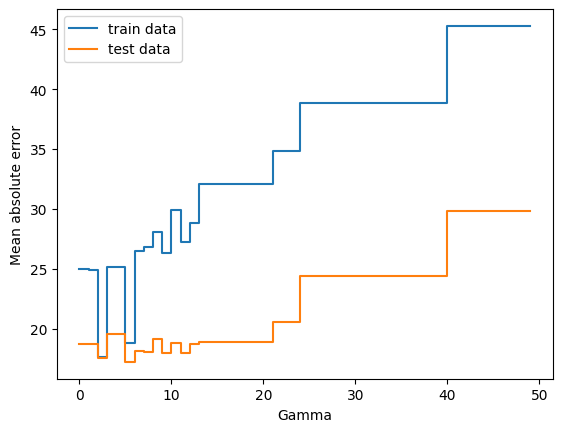

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel("Gamma")
ax.set_ylabel("Mean absolute error")

#ax.set_title("나무 복잡도 증가에 따른 오분류율 그래프")
ax.plot(gamma_list, train_scores,  label="train data", drawstyle="steps-post")
ax.plot(gamma_list, test_scores,  label="test data", drawstyle="steps-post")

ax.legend()
#plt.xlim(0.7)
plt.show()
plt.close('all')

In [ ]:
# 최적의 gamma값 도출
best_gamma = gamma_list[np.argmin(test_scores)]
print(f"최적의 gamma 값: {best_gamma}")

# 최적의 gamma값으로 최종 모델 학습
final_reg = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100,
                             learning_rate=0.4,
                             min_child_weight=10,
                             colsample_bytree=0.5,
                             max_depth=8,
                            #  reg_alpha=best_alpha,
                             min_split_loss=best_gamma, # gamma를 뜻함.
                             reg_lambda=0.8,
                             eval_metric='rmse')

final_reg.fit(X_train, Y_train, eval_set=eval_set, early_stopping_rounds=20)

# 최종 모델 평가
final_preds = final_reg.predict(X_test)
print_all_reg(Y_test, final_preds)


최적의 gamma 값: 5
[0]	validation_0-rmse:31.26522
[1]	validation_0-rmse:28.00976
[2]	validation_0-rmse:31.54139
[3]	validation_0-rmse:31.78185
[4]	validation_0-rmse:32.81865
[5]	validation_0-rmse:32.62736
[6]	validation_0-rmse:34.99199
[7]	validation_0-rmse:37.13664
[8]	validation_0-rmse:36.44333
[9]	validation_0-rmse:37.81371
[10]	validation_0-rmse:39.38472
[11]	validation_0-rmse:40.37469
[12]	validation_0-rmse:39.99968
[13]	validation_0-rmse:42.04719
[14]	validation_0-rmse:41.94721
[15]	validation_0-rmse:42.07418
[16]	validation_0-rmse:42.12480
[17]	validation_0-rmse:42.22336
[18]	validation_0-rmse:42.39217
[19]	validation_0-rmse:42.66533
[20]	validation_0-rmse:42.66101


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


model의 MSE 값은 784.547
model의 MAE 값은 21.593
model의 MAPE 값은 1.357
model의 r2 값은 0.508


### lambda에 따른 성능 비교
* L2 정규화(규제) 파라미터이다.
* 커질수록 보수적인 모델을 생성하고 오버 피팅을 방지함
* 지나치게 클 경우 언더 피팅이 발생함
* noise나 outlier 값들이 크게 튀는 데이터들을 어느 정도 잡아준다고 보면 됨

In [ ]:
# lambda 값에 따른 성능 비교
lambda_list = list(np.arange(0, 50, 2))

# 검증용 데이터셋 정의
eval_set = [(X_test, Y_test)]

train_scores = []
test_scores = []

# 모든 lambda 대하여 모델 적합, 최적의lambda값 도출
for lambdaa in lambda_list:
    reg = xgb.XGBRegressor(objective='reg:absoluteerror',
                           n_estimators=100,
                           learning_rate=0.4,
                           min_child_weight=10,
                           colsample_bytree=0.5,
                           max_depth=8,
                          #  reg_alpha=alpha,
                           reg_lambda=lambdaa,
                           eval_metric='mae')

    reg.fit(X_train, Y_train, eval_set=eval_set, early_stopping_rounds=20)

    preds_train = reg.predict(X_train)
    preds = reg.predict(X_test)

    train_scores.append(mean_absolute_error(Y_train, preds_train))  # MAE for training data
    test_scores.append(mean_absolute_error(Y_test, preds))  # MAE for testing data


[0]	validation_0-mae:23.47143
[1]	validation_0-mae:20.31714
[2]	validation_0-mae:19.03914
[3]	validation_0-mae:19.49571
[4]	validation_0-mae:20.16152
[5]	validation_0-mae:19.41852
[6]	validation_0-mae:19.20777
[7]	validation_0-mae:19.25452
[8]	validation_0-mae:19.11539
[9]	validation_0-mae:20.10132
[10]	validation_0-mae:20.54058
[11]	validation_0-mae:20.67814
[12]	validation_0-mae:20.91919
[13]	validation_0-mae:20.87772
[14]	validation_0-mae:21.02527


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-mae:20.92147
[16]	validation_0-mae:20.89425
[17]	validation_0-mae:20.92138
[18]	validation_0-mae:21.03714
[19]	validation_0-mae:21.23743
[20]	validation_0-mae:21.16769
[21]	validation_0-mae:21.13051
[0]	validation_0-mae:24.05714
[1]	validation_0-mae:21.56286
[2]	validation_0-mae:19.87086
[3]	validation_0-mae:18.58434
[4]	validation_0-mae:19.03314
[5]	validation_0-mae:19.49462
[6]	validation_0-mae:19.28748
[7]	validation_0-mae:19.30408
[8]	validation_0-mae:19.60661
[9]	validation_0-mae:19.27255
[10]	validation_0-mae:18.97497
[11]	validation_0-mae:19.30669
[12]	validation_0-mae:19.52374
[13]	validation_0-mae:19.76800
[14]	validation_0-mae:19.66393
[15]	validation_0-mae:19.57315
[16]	validation_0-mae:19.54809
[17]	validation_0-mae:19.49064
[18]	validation_0-mae:19.39993
[19]	validation_0-mae:19.42908
[20]	validation_0-mae:19.52544


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-mae:19.51536
[22]	validation_0-mae:20.07344
[0]	validation_0-mae:24.14286
[1]	validation_0-mae:21.31857
[2]	validation_0-mae:20.45371
[3]	validation_0-mae:18.68423
[4]	validation_0-mae:19.28579
[5]	validation_0-mae:19.19448
[6]	validation_0-mae:19.36773
[7]	validation_0-mae:19.18082
[8]	validation_0-mae:18.78630
[9]	validation_0-mae:19.29744
[10]	validation_0-mae:19.45434
[11]	validation_0-mae:19.42857
[12]	validation_0-mae:19.53153
[13]	validation_0-mae:19.66942
[14]	validation_0-mae:19.64743
[15]	validation_0-mae:19.65317
[16]	validation_0-mae:19.55354
[17]	validation_0-mae:19.72048
[18]	validation_0-mae:19.59910
[19]	validation_0-mae:19.54306
[20]	validation_0-mae:19.68020
[21]	validation_0-mae:19.76325


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22]	validation_0-mae:19.80361
[0]	validation_0-mae:24.14286
[1]	validation_0-mae:21.28714
[2]	validation_0-mae:21.38771
[3]	validation_0-mae:19.67606
[4]	validation_0-mae:21.69113
[5]	validation_0-mae:21.38576
[6]	validation_0-mae:21.55715
[7]	validation_0-mae:22.35875
[8]	validation_0-mae:22.26169
[9]	validation_0-mae:22.02711
[10]	validation_0-mae:22.12199
[11]	validation_0-mae:22.39489
[12]	validation_0-mae:22.16134
[13]	validation_0-mae:22.14093
[14]	validation_0-mae:22.05703
[15]	validation_0-mae:22.47552
[16]	validation_0-mae:22.31058
[17]	validation_0-mae:22.27083
[18]	validation_0-mae:22.16805
[19]	validation_0-mae:22.19346
[20]	validation_0-mae:22.18919


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-mae:22.13498
[22]	validation_0-mae:21.90830
[23]	validation_0-mae:22.05028
[0]	validation_0-mae:24.14286
[1]	validation_0-mae:20.61429
[2]	validation_0-mae:19.36543
[3]	validation_0-mae:17.76040
[4]	validation_0-mae:17.93761
[5]	validation_0-mae:18.23669
[6]	validation_0-mae:18.04518
[7]	validation_0-mae:17.62663
[8]	validation_0-mae:19.01809
[9]	validation_0-mae:19.66636
[10]	validation_0-mae:19.97777
[11]	validation_0-mae:20.49808
[12]	validation_0-mae:20.46347
[13]	validation_0-mae:20.23940
[14]	validation_0-mae:20.52174
[15]	validation_0-mae:20.82573
[16]	validation_0-mae:20.59287
[17]	validation_0-mae:20.68578
[18]	validation_0-mae:20.60484
[19]	validation_0-mae:20.77966
[20]	validation_0-mae:20.77892
[21]	validation_0-mae:20.74907
[22]	validation_0-mae:20.70566


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[23]	validation_0-mae:21.22254
[24]	validation_0-mae:21.09072
[25]	validation_0-mae:21.12289
[26]	validation_0-mae:21.07406
[27]	validation_0-mae:21.05266
[0]	validation_0-mae:24.14286
[1]	validation_0-mae:21.84143
[2]	validation_0-mae:20.55457
[3]	validation_0-mae:18.89240
[4]	validation_0-mae:19.46081
[5]	validation_0-mae:19.81955
[6]	validation_0-mae:19.11580
[7]	validation_0-mae:20.26886
[8]	validation_0-mae:20.42173
[9]	validation_0-mae:20.18503
[10]	validation_0-mae:20.25389
[11]	validation_0-mae:20.15087
[12]	validation_0-mae:20.20472
[13]	validation_0-mae:19.97233
[14]	validation_0-mae:19.93817
[15]	validation_0-mae:19.88534
[16]	validation_0-mae:20.27262
[17]	validation_0-mae:20.17933
[18]	validation_0-mae:20.05386
[19]	validation_0-mae:20.12637
[20]	validation_0-mae:20.13515
[21]	validation_0-mae:20.04248


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22]	validation_0-mae:19.99495
[0]	validation_0-mae:24.14286
[1]	validation_0-mae:21.66143
[2]	validation_0-mae:20.86314
[3]	validation_0-mae:19.79886
[4]	validation_0-mae:20.20422
[5]	validation_0-mae:20.14532
[6]	validation_0-mae:20.90271
[7]	validation_0-mae:20.50629
[8]	validation_0-mae:20.39596
[9]	validation_0-mae:20.78856
[10]	validation_0-mae:20.32336
[11]	validation_0-mae:20.53283
[12]	validation_0-mae:20.57518
[13]	validation_0-mae:20.76657
[14]	validation_0-mae:20.31773
[15]	validation_0-mae:20.38306
[16]	validation_0-mae:20.36308
[17]	validation_0-mae:20.27249
[18]	validation_0-mae:20.28458
[19]	validation_0-mae:20.41299
[20]	validation_0-mae:20.36947


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-mae:20.12764
[22]	validation_0-mae:20.23175
[23]	validation_0-mae:20.24055
[0]	validation_0-mae:24.14286
[1]	validation_0-mae:21.66143
[2]	validation_0-mae:20.86314
[3]	validation_0-mae:19.79886
[4]	validation_0-mae:20.20422
[5]	validation_0-mae:19.97578
[6]	validation_0-mae:20.13398
[7]	validation_0-mae:23.22860
[8]	validation_0-mae:23.33049
[9]	validation_0-mae:23.17317
[10]	validation_0-mae:23.10006
[11]	validation_0-mae:23.05769
[12]	validation_0-mae:23.10497
[13]	validation_0-mae:23.08143
[14]	validation_0-mae:24.50086
[15]	validation_0-mae:24.78595
[16]	validation_0-mae:24.74534
[17]	validation_0-mae:24.99499
[18]	validation_0-mae:25.00896
[19]	validation_0-mae:24.90534
[20]	validation_0-mae:24.72346
[21]	validation_0-mae:25.23966
[22]	validation_0-mae:25.36435


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:24.14286
[1]	validation_0-mae:21.66143
[2]	validation_0-mae:20.86314
[3]	validation_0-mae:19.79886
[4]	validation_0-mae:20.20422
[5]	validation_0-mae:19.97578
[6]	validation_0-mae:21.47424
[7]	validation_0-mae:22.76296
[8]	validation_0-mae:22.54500
[9]	validation_0-mae:22.14005
[10]	validation_0-mae:22.72054
[11]	validation_0-mae:23.84980
[12]	validation_0-mae:24.04115
[13]	validation_0-mae:23.89096
[14]	validation_0-mae:23.59880
[15]	validation_0-mae:23.60902
[16]	validation_0-mae:24.16359
[17]	validation_0-mae:24.21039
[18]	validation_0-mae:23.94662
[19]	validation_0-mae:23.81468
[20]	validation_0-mae:23.82233
[21]	validation_0-mae:23.89833
[22]	validation_0-mae:23.83959
[23]	validation_0-mae:23.77758


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:24.14286
[1]	validation_0-mae:21.66143
[2]	validation_0-mae:20.62086
[3]	validation_0-mae:19.36154
[4]	validation_0-mae:19.28191
[5]	validation_0-mae:19.71789
[6]	validation_0-mae:21.29665
[7]	validation_0-mae:21.10252
[8]	validation_0-mae:21.06615
[9]	validation_0-mae:22.43768
[10]	validation_0-mae:21.82244
[11]	validation_0-mae:21.68650
[12]	validation_0-mae:21.75447
[13]	validation_0-mae:21.71234
[14]	validation_0-mae:21.49386
[15]	validation_0-mae:21.63863
[16]	validation_0-mae:21.60284
[17]	validation_0-mae:21.93005
[18]	validation_0-mae:21.88807
[19]	validation_0-mae:21.80634


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-mae:22.35303
[21]	validation_0-mae:23.38894
[22]	validation_0-mae:23.30300
[23]	validation_0-mae:23.31776
[0]	validation_0-mae:24.14286
[1]	validation_0-mae:21.30714
[2]	validation_0-mae:20.24514
[3]	validation_0-mae:18.41251
[4]	validation_0-mae:20.43080
[5]	validation_0-mae:21.94913
[6]	validation_0-mae:22.99876
[7]	validation_0-mae:23.83973
[8]	validation_0-mae:24.15508
[9]	validation_0-mae:24.28435
[10]	validation_0-mae:24.64666
[11]	validation_0-mae:24.70678
[12]	validation_0-mae:24.73446
[13]	validation_0-mae:24.66345
[14]	validation_0-mae:24.72901
[15]	validation_0-mae:24.72778
[16]	validation_0-mae:24.86602
[17]	validation_0-mae:24.86789
[18]	validation_0-mae:24.73564
[19]	validation_0-mae:24.65972
[20]	validation_0-mae:24.55461
[21]	validation_0-mae:24.71465
[22]	validation_0-mae:24.70834
[23]	validation_0-mae:24.86402


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:24.14286
[1]	validation_0-mae:21.30714
[2]	validation_0-mae:20.24514
[3]	validation_0-mae:18.41251
[4]	validation_0-mae:20.43080
[5]	validation_0-mae:21.94913
[6]	validation_0-mae:22.99876
[7]	validation_0-mae:23.73142
[8]	validation_0-mae:23.73851
[9]	validation_0-mae:23.54792
[10]	validation_0-mae:23.71245
[11]	validation_0-mae:24.35852
[12]	validation_0-mae:24.27241
[13]	validation_0-mae:24.28286
[14]	validation_0-mae:24.29560
[15]	validation_0-mae:24.24486
[16]	validation_0-mae:24.18242
[17]	validation_0-mae:24.32757
[18]	validation_0-mae:24.11721
[19]	validation_0-mae:24.06204
[20]	validation_0-mae:24.03728
[21]	validation_0-mae:23.99787
[22]	validation_0-mae:24.02945


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:24.14286
[1]	validation_0-mae:21.30714
[2]	validation_0-mae:20.24514
[3]	validation_0-mae:18.41251
[4]	validation_0-mae:20.43080
[5]	validation_0-mae:21.94913
[6]	validation_0-mae:22.99876
[7]	validation_0-mae:23.73142
[8]	validation_0-mae:23.73851
[9]	validation_0-mae:23.54792
[10]	validation_0-mae:23.71245
[11]	validation_0-mae:24.35852
[12]	validation_0-mae:24.27241
[13]	validation_0-mae:24.28286
[14]	validation_0-mae:24.29560
[15]	validation_0-mae:24.24486
[16]	validation_0-mae:24.18242
[17]	validation_0-mae:24.32757
[18]	validation_0-mae:24.11721
[19]	validation_0-mae:24.06204
[20]	validation_0-mae:24.03728
[21]	validation_0-mae:23.99787
[22]	validation_0-mae:24.02945
[23]	validation_0-mae:24.07467


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:24.14286
[1]	validation_0-mae:21.30714
[2]	validation_0-mae:20.24514
[3]	validation_0-mae:18.41251
[4]	validation_0-mae:20.43080
[5]	validation_0-mae:21.94913
[6]	validation_0-mae:22.99876
[7]	validation_0-mae:22.96253
[8]	validation_0-mae:23.23671
[9]	validation_0-mae:23.53619
[10]	validation_0-mae:24.26982
[11]	validation_0-mae:24.27653
[12]	validation_0-mae:24.16609
[13]	validation_0-mae:24.53216
[14]	validation_0-mae:24.51580
[15]	validation_0-mae:26.05151
[16]	validation_0-mae:26.18225
[17]	validation_0-mae:26.09882
[18]	validation_0-mae:26.12731
[19]	validation_0-mae:26.36823
[20]	validation_0-mae:26.50147
[21]	validation_0-mae:26.58506
[22]	validation_0-mae:26.69783


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[23]	validation_0-mae:26.65860
[0]	validation_0-mae:24.14286
[1]	validation_0-mae:21.30714
[2]	validation_0-mae:20.24514
[3]	validation_0-mae:18.49640
[4]	validation_0-mae:20.25282
[5]	validation_0-mae:20.72041
[6]	validation_0-mae:20.69917
[7]	validation_0-mae:20.64083
[8]	validation_0-mae:20.32851
[9]	validation_0-mae:21.33943
[10]	validation_0-mae:21.07928
[11]	validation_0-mae:20.86139
[12]	validation_0-mae:21.07571
[13]	validation_0-mae:20.89435
[14]	validation_0-mae:23.18845
[15]	validation_0-mae:23.12462
[16]	validation_0-mae:23.26406
[17]	validation_0-mae:23.25923
[18]	validation_0-mae:23.24848
[19]	validation_0-mae:23.34523
[20]	validation_0-mae:27.11322
[21]	validation_0-mae:27.01462
[22]	validation_0-mae:26.76050


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:24.14286
[1]	validation_0-mae:21.06857
[2]	validation_0-mae:20.00886
[3]	validation_0-mae:18.26560
[4]	validation_0-mae:20.18939
[5]	validation_0-mae:21.21054
[6]	validation_0-mae:21.67862
[7]	validation_0-mae:21.91588
[8]	validation_0-mae:21.78671
[9]	validation_0-mae:21.71992
[10]	validation_0-mae:21.79876
[11]	validation_0-mae:21.76151
[12]	validation_0-mae:21.64617
[13]	validation_0-mae:21.55281
[14]	validation_0-mae:21.77832
[15]	validation_0-mae:22.03734
[16]	validation_0-mae:22.99543
[17]	validation_0-mae:23.14648
[18]	validation_0-mae:23.29570
[19]	validation_0-mae:23.15782
[20]	validation_0-mae:22.89169
[21]	validation_0-mae:22.97508
[22]	validation_0-mae:23.06519
[23]	validation_0-mae:23.25295


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:24.14286
[1]	validation_0-mae:21.06857
[2]	validation_0-mae:20.00886
[3]	validation_0-mae:18.31223
[4]	validation_0-mae:18.90034
[5]	validation_0-mae:19.04866
[6]	validation_0-mae:18.48375
[7]	validation_0-mae:18.64305
[8]	validation_0-mae:19.17255
[9]	validation_0-mae:18.98052
[10]	validation_0-mae:19.28513
[11]	validation_0-mae:19.60352
[12]	validation_0-mae:19.59904
[13]	validation_0-mae:19.70112
[14]	validation_0-mae:19.55712
[15]	validation_0-mae:19.64106
[16]	validation_0-mae:19.68001
[17]	validation_0-mae:19.66273
[18]	validation_0-mae:19.80414
[19]	validation_0-mae:19.75788
[20]	validation_0-mae:19.63119
[21]	validation_0-mae:19.51462
[22]	validation_0-mae:19.68087


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:24.14286
[1]	validation_0-mae:20.87429
[2]	validation_0-mae:19.88086
[3]	validation_0-mae:18.04263
[4]	validation_0-mae:18.61314
[5]	validation_0-mae:19.62460
[6]	validation_0-mae:20.18826
[7]	validation_0-mae:20.10375
[8]	validation_0-mae:21.20114
[9]	validation_0-mae:21.02781
[10]	validation_0-mae:21.08545
[11]	validation_0-mae:21.21704
[12]	validation_0-mae:20.95549
[13]	validation_0-mae:21.84968
[14]	validation_0-mae:21.73121
[15]	validation_0-mae:21.71086
[16]	validation_0-mae:21.64894
[17]	validation_0-mae:22.94211
[18]	validation_0-mae:22.95991
[19]	validation_0-mae:22.91173
[20]	validation_0-mae:22.91489
[21]	validation_0-mae:22.73863
[22]	validation_0-mae:22.79750
[23]	validation_0-mae:22.91479


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:24.14286
[1]	validation_0-mae:20.87429
[2]	validation_0-mae:19.88086
[3]	validation_0-mae:18.04263
[4]	validation_0-mae:18.61314
[5]	validation_0-mae:19.62460
[6]	validation_0-mae:20.18826
[7]	validation_0-mae:20.10375
[8]	validation_0-mae:21.20114
[9]	validation_0-mae:21.02781
[10]	validation_0-mae:21.08545
[11]	validation_0-mae:21.21704
[12]	validation_0-mae:20.95549
[13]	validation_0-mae:21.84968
[14]	validation_0-mae:21.73121
[15]	validation_0-mae:21.71086
[16]	validation_0-mae:21.64894
[17]	validation_0-mae:22.94211
[18]	validation_0-mae:22.95991
[19]	validation_0-mae:22.91173
[20]	validation_0-mae:22.91489
[21]	validation_0-mae:22.73335
[22]	validation_0-mae:22.74948


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:24.14286
[1]	validation_0-mae:20.87429
[2]	validation_0-mae:19.88086
[3]	validation_0-mae:18.04263
[4]	validation_0-mae:18.61314
[5]	validation_0-mae:19.62460
[6]	validation_0-mae:20.18826
[7]	validation_0-mae:20.10375
[8]	validation_0-mae:21.20114
[9]	validation_0-mae:21.02781
[10]	validation_0-mae:21.08545
[11]	validation_0-mae:21.21704
[12]	validation_0-mae:20.95549
[13]	validation_0-mae:21.84968
[14]	validation_0-mae:21.73121
[15]	validation_0-mae:21.71086
[16]	validation_0-mae:21.64894
[17]	validation_0-mae:22.94211
[18]	validation_0-mae:22.95991
[19]	validation_0-mae:22.91173
[20]	validation_0-mae:22.91489
[21]	validation_0-mae:22.73335
[22]	validation_0-mae:22.74948


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[23]	validation_0-mae:22.75434
[0]	validation_0-mae:24.14286
[1]	validation_0-mae:20.87429
[2]	validation_0-mae:19.88086
[3]	validation_0-mae:18.04263
[4]	validation_0-mae:18.61314
[5]	validation_0-mae:19.62460
[6]	validation_0-mae:20.18826
[7]	validation_0-mae:20.10375
[8]	validation_0-mae:21.20114
[9]	validation_0-mae:21.02781
[10]	validation_0-mae:21.08545
[11]	validation_0-mae:21.21704
[12]	validation_0-mae:20.95549
[13]	validation_0-mae:21.84968
[14]	validation_0-mae:21.73121
[15]	validation_0-mae:21.71086
[16]	validation_0-mae:21.64894
[17]	validation_0-mae:22.94211
[18]	validation_0-mae:22.95991
[19]	validation_0-mae:22.91173
[20]	validation_0-mae:22.91489
[21]	validation_0-mae:22.96785
[22]	validation_0-mae:23.00907


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:24.55000
[1]	validation_0-mae:21.38429
[2]	validation_0-mae:19.58314
[3]	validation_0-mae:19.17994
[4]	validation_0-mae:19.48470
[5]	validation_0-mae:19.52591
[6]	validation_0-mae:19.48513
[7]	validation_0-mae:19.76187
[8]	validation_0-mae:19.68645
[9]	validation_0-mae:19.35124
[10]	validation_0-mae:19.96744
[11]	validation_0-mae:19.16093
[12]	validation_0-mae:19.37757
[13]	validation_0-mae:18.99793
[14]	validation_0-mae:18.78556
[15]	validation_0-mae:18.69231
[16]	validation_0-mae:18.62632
[17]	validation_0-mae:18.62697
[18]	validation_0-mae:18.44777
[19]	validation_0-mae:18.58530
[20]	validation_0-mae:18.44258
[21]	validation_0-mae:18.44537
[22]	validation_0-mae:18.18484
[23]	validation_0-mae:18.34724


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-mae:18.50725
[25]	validation_0-mae:18.66205
[26]	validation_0-mae:18.67165
[27]	validation_0-mae:18.69470
[28]	validation_0-mae:18.53102
[29]	validation_0-mae:18.55181
[30]	validation_0-mae:21.80287
[31]	validation_0-mae:21.54594
[32]	validation_0-mae:21.51718
[33]	validation_0-mae:21.49770
[34]	validation_0-mae:21.51630
[35]	validation_0-mae:21.55541
[36]	validation_0-mae:21.53748
[37]	validation_0-mae:21.48890
[38]	validation_0-mae:21.53523
[39]	validation_0-mae:21.53183
[40]	validation_0-mae:21.56275
[41]	validation_0-mae:21.53770
[0]	validation_0-mae:24.55000
[1]	validation_0-mae:21.38429
[2]	validation_0-mae:19.58314
[3]	validation_0-mae:19.17994
[4]	validation_0-mae:19.48470
[5]	validation_0-mae:19.52591
[6]	validation_0-mae:19.48513
[7]	validation_0-mae:19.76187
[8]	validation_0-mae:19.68645
[9]	validation_0-mae:19.35124
[10]	validation_0-mae:19.96744
[11]	validation_0-mae:19.16093
[12]	validation_0-mae:19.37757
[13]	validation_0-mae:18.99793
[14]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22]	validation_0-mae:18.58769
[23]	validation_0-mae:18.56087
[24]	validation_0-mae:18.50112
[25]	validation_0-mae:18.61291
[26]	validation_0-mae:18.58995
[27]	validation_0-mae:18.49631
[28]	validation_0-mae:18.50639
[29]	validation_0-mae:19.01102
[30]	validation_0-mae:18.99372
[31]	validation_0-mae:18.99479
[32]	validation_0-mae:19.02746
[33]	validation_0-mae:19.06601
[34]	validation_0-mae:19.06239
[35]	validation_0-mae:19.10000
[36]	validation_0-mae:19.11003
[37]	validation_0-mae:19.13817
[38]	validation_0-mae:19.19082
[39]	validation_0-mae:19.45166
[40]	validation_0-mae:19.41812
[0]	validation_0-mae:24.55000
[1]	validation_0-mae:21.38429
[2]	validation_0-mae:19.51857
[3]	validation_0-mae:19.04263
[4]	validation_0-mae:18.26344
[5]	validation_0-mae:19.29672
[6]	validation_0-mae:19.56215
[7]	validation_0-mae:20.15143
[8]	validation_0-mae:19.84565
[9]	validation_0-mae:19.46238
[10]	validation_0-mae:19.94277
[11]	validation_0-mae:20.14905
[12]	validation_0-mae:19.51867
[13]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:24.55000
[1]	validation_0-mae:21.38429
[2]	validation_0-mae:19.51857
[3]	validation_0-mae:19.04263
[4]	validation_0-mae:18.26344
[5]	validation_0-mae:19.29672
[6]	validation_0-mae:19.56215
[7]	validation_0-mae:20.15143
[8]	validation_0-mae:19.84565
[9]	validation_0-mae:19.46238
[10]	validation_0-mae:19.94277
[11]	validation_0-mae:20.14905
[12]	validation_0-mae:19.51867
[13]	validation_0-mae:19.27459
[14]	validation_0-mae:19.24161
[15]	validation_0-mae:19.47670
[16]	validation_0-mae:19.53816
[17]	validation_0-mae:19.45914
[18]	validation_0-mae:19.49181
[19]	validation_0-mae:19.40271
[20]	validation_0-mae:19.13506
[21]	validation_0-mae:19.07670
[22]	validation_0-mae:18.98720


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[23]	validation_0-mae:18.95851
[24]	validation_0-mae:18.94042


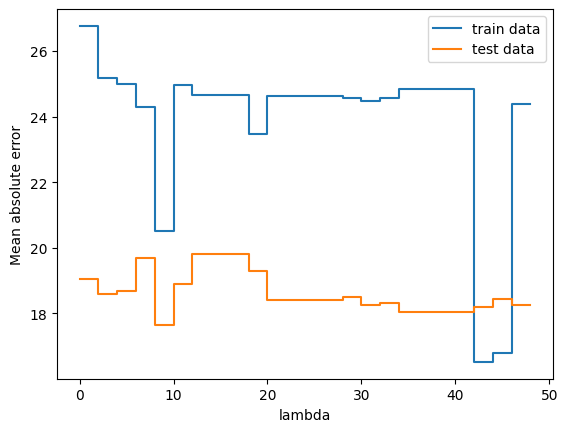

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel("lambda")
ax.set_ylabel("Mean absolute error")

#ax.set_title("나무 복잡도 증가에 따른 오분류율 그래프")
ax.plot(lambda_list, train_scores,  label="train data", drawstyle="steps-post")
ax.plot(lambda_list, test_scores,  label="test data", drawstyle="steps-post")


ax.legend()
#plt.xlim(0.7)
plt.show()
plt.close('all')

In [ ]:
# 최적의 lambda값 도출
best_lambda = lambda_list[np.argmin(test_scores)]
print(f"최적의 lambda 값: {best_lambda}")

# 최적의 lambda값으로 최종 모델 학습
final_reg = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100,
                             learning_rate=0.4,
                             min_child_weight=10,
                             colsample_bytree=0.5,
                             max_depth=8,
                            #  reg_alpha=best_alpha,
                             reg_lambda=best_lambda,
                             eval_metric='rmse')

final_reg.fit(X_train, Y_train, eval_set=eval_set, early_stopping_rounds=20)

# 최종 모델 평가
final_preds = final_reg.predict(X_test)
print_all_reg(Y_test, final_preds)


최적의 lambda 값: 8
[0]	validation_0-rmse:37.09326
[1]	validation_0-rmse:31.78108
[2]	validation_0-rmse:30.70537
[3]	validation_0-rmse:31.72933
[4]	validation_0-rmse:31.18487
[5]	validation_0-rmse:35.12506
[6]	validation_0-rmse:35.64401
[7]	validation_0-rmse:34.84396
[8]	validation_0-rmse:34.21331
[9]	validation_0-rmse:36.06145
[10]	validation_0-rmse:35.90158
[11]	validation_0-rmse:34.12625
[12]	validation_0-rmse:34.57765
[13]	validation_0-rmse:35.04819
[14]	validation_0-rmse:35.51908
[15]	validation_0-rmse:34.94532


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-rmse:35.41520
[17]	validation_0-rmse:36.27182
[18]	validation_0-rmse:36.87393
[19]	validation_0-rmse:36.43044
[20]	validation_0-rmse:36.67592
[21]	validation_0-rmse:37.50436
[22]	validation_0-rmse:37.58308
model의 MSE 값은 942.820
model의 MAE 값은 23.453
model의 MAPE 값은 1.434
model의 r2 값은 0.408


In [ ]:
from xgboost import plot_importance
import seaborn as sns

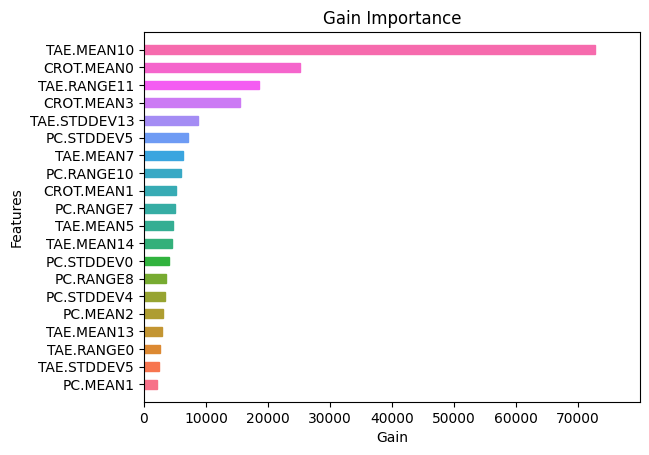

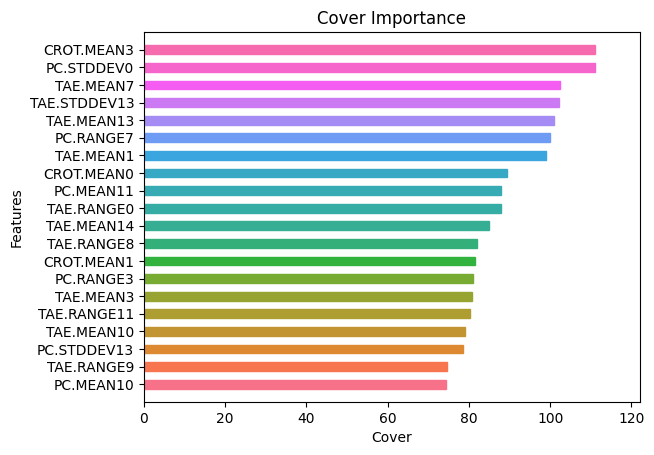

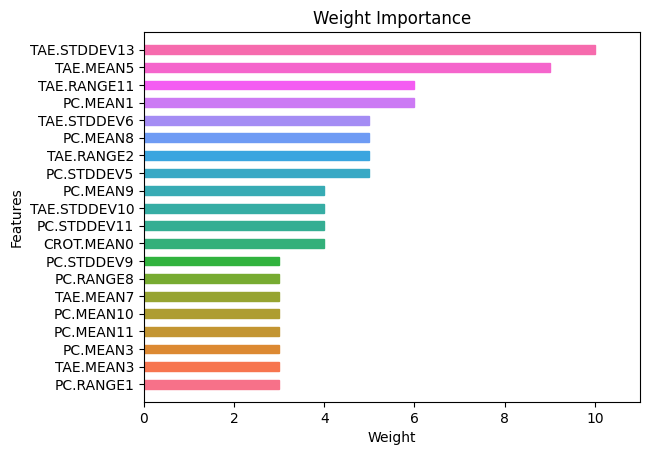

In [ ]:
# 변수 중요도 시각화 (gain)
ax = plot_importance(final_reg, importance_type='gain', max_num_features=20, height=0.5, xlabel='Gain', title='Gain Importance', show_values=False, grid=False)
plt.gca().set_facecolor('white')  # 배경색을 흰색으로 설정

# Seaborn palette 적용
palette = sns.color_palette("husl", 20)

for bar, color in zip(ax.patches, palette):
    bar.set_color(color)

plt.show()

# 변수 중요도 시각화 (cover)
ax = plot_importance(final_reg, importance_type='cover', max_num_features=20, height=0.5, xlabel='Cover', title='Cover Importance', show_values=False, grid=False)
plt.gca().set_facecolor('white')  # 배경색을 흰색으로 설정


for bar, color in zip(ax.patches, palette):
    bar.set_color(color)

plt.show()

# 변수 중요도 시각화 (weight)
ax = plot_importance(final_reg, importance_type='weight', max_num_features=20, height=0.5, xlabel='Weight', title='Weight Importance', show_values=False, grid=False)
plt.gca().set_facecolor('white')  # 배경색을 흰색으로 설정

for bar, color in zip(ax.patches, palette):
    bar.set_color(color)

plt.show()

In [ ]:
#트리 시각화
#!pip install graphviz python-graphviz

<Axes: >

<Figure size 1200x2400 with 0 Axes>

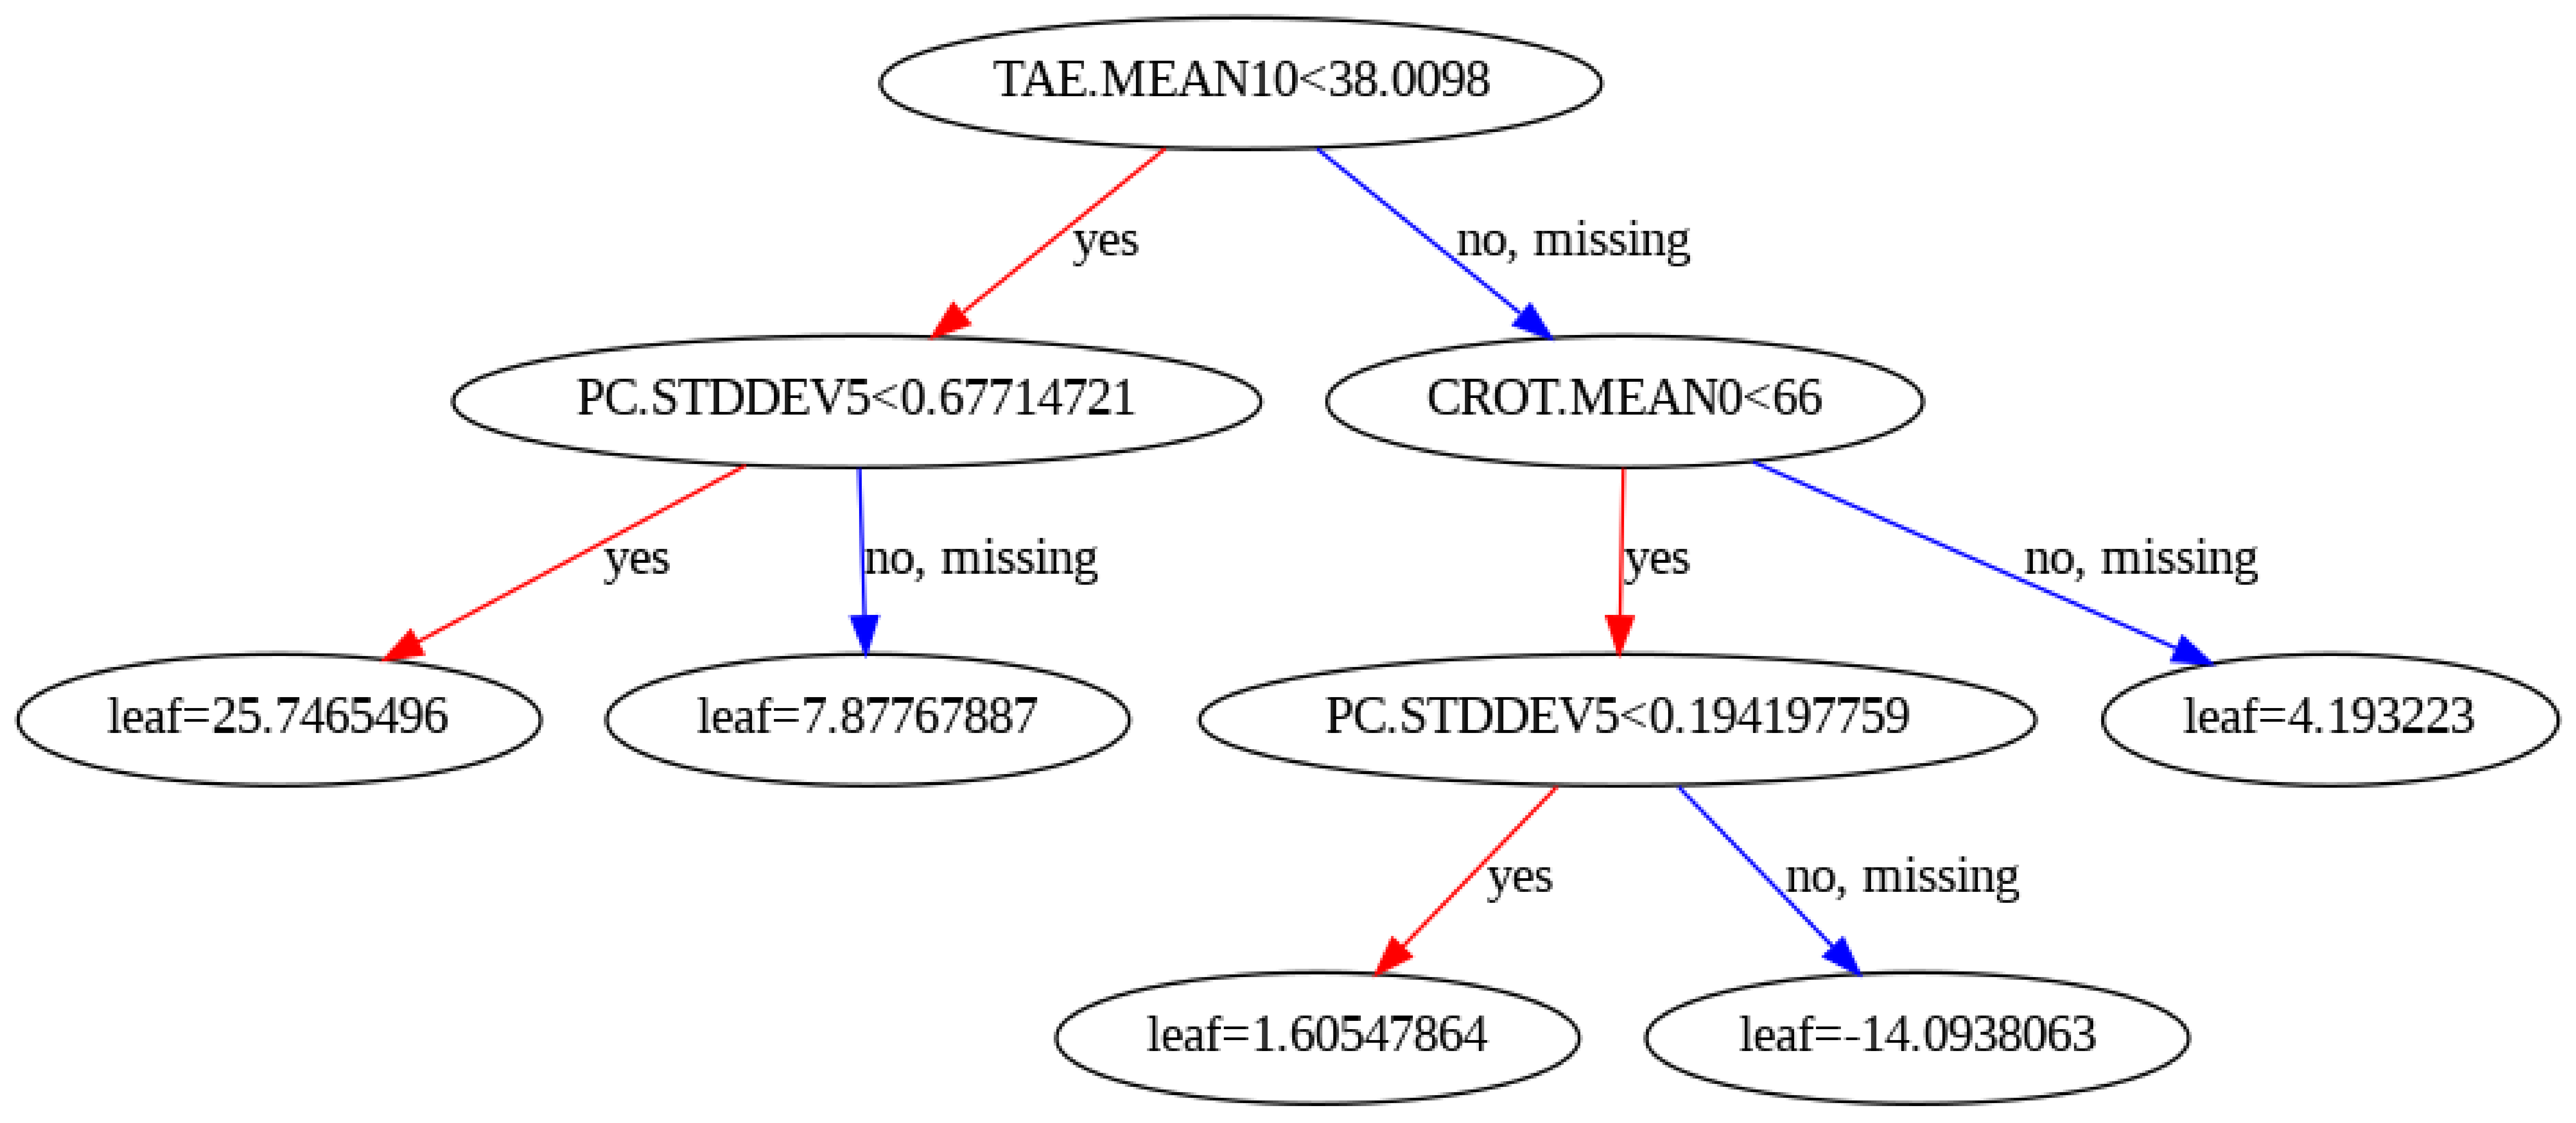

In [ ]:
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 100, 200

# 트리 시각화
plt.figure(figsize=(12, 24))
xgb.plot_tree(final_reg, num_trees=0, rankdir="TB") #TB: 위에서 아래로 트리 그리기